# Car Parking Prediction Challenge

## 1. Generate anchors for the dataset

In [1]:
import random
import argparse
import numpy as np
import voc
import json

In [2]:
def IOU(ann, centroids):
    w, h = ann
    similarities = []

    for centroid in centroids:
        c_w, c_h = centroid

        if c_w >= w and c_h >= h:
            similarity = w*h/(c_w*c_h)
        elif c_w >= w and c_h <= h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w <= w and c_h >= h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape

    return np.array(similarities)

def avg_IOU(anns, centroids):
    n,d = anns.shape
    sum = 0.

    for i in range(anns.shape[0]):
        sum+= max(IOU(anns[i], centroids))

    return sum/n

def print_anchors(centroids):
    out_string = ''

    anchors = centroids.copy()

    widths = anchors[:, 0]
    sorted_indices = np.argsort(widths)

    r = "anchors: ["
    for i in sorted_indices:
        out_string += str(int(anchors[i,0]*416)) + ',' + str(int(anchors[i,1]*416)) + ', '
            
    print(out_string[:-2])

def run_kmeans(ann_dims, anchor_num):
    ann_num = ann_dims.shape[0]
    iterations = 0
    prev_assignments = np.ones(ann_num)*(-1)
    iteration = 0
    old_distances = np.zeros((ann_num, anchor_num))

    indices = [random.randrange(ann_dims.shape[0]) for i in range(anchor_num)]
    centroids = ann_dims[indices]
    anchor_dim = ann_dims.shape[1]

    while True:
        distances = []
        iteration += 1
        for i in range(ann_num):
            d = 1 - IOU(ann_dims[i], centroids)
            distances.append(d)
        distances = np.array(distances) # distances.shape = (ann_num, anchor_num)

        print("iteration {}: dists = {}".format(iteration, np.sum(np.abs(old_distances-distances))))

        #assign samples to centroids
        assignments = np.argmin(distances,axis=1)

        if (assignments == prev_assignments).all() :
            return centroids

        #calculate new centroids
        centroid_sums=np.zeros((anchor_num, anchor_dim), np.float)
        for i in range(ann_num):
            centroid_sums[assignments[i]]+=ann_dims[i]
        for j in range(anchor_num):
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j) + 1e-6)

        prev_assignments = assignments.copy()
        old_distances = distances.copy()

def _main_(conf, anchors):
    config_path = conf
    num_anchors = anchors

    with open(config_path) as config_buffer:
        config = json.loads(config_buffer.read())

    print(config['train']['train_annot_folder'],
        config['train']['train_image_folder'],
        config['train']['cache_name'],
        '1')

    train_imgs, train_labels = voc.parse_voc_annotationv1(
        config['train']['train_annot_folder'],
        config['train']['train_image_folder'],
        config['train']['cache_name'],
        '1'
    )

    # run k_mean to find the anchors
    annotation_dims = []
    for image in train_imgs:
        print(image['filename'])
        for obj in image['object']:
            relative_w = (float(obj['xmax']) - float(obj['xmin']))/image['width']
            relatice_h = (float(obj["ymax"]) - float(obj['ymin']))/image['height']
            annotation_dims.append(tuple(map(float, (relative_w,relatice_h))))

    annotation_dims = np.array(annotation_dims)
    print(annotation_dims, num_anchors)
    centroids = run_kmeans(annotation_dims, num_anchors)

    # write anchors to file
    print('\naverage IOU for', num_anchors, 'anchors:', '%0.2f' % avg_IOU(annotation_dims, centroids))
    print_anchors(centroids)

In [3]:
import sys
%tb
if __name__ == '__main__':
    _main_('config.json',9)

No traceback available to show.


C:\Users\tejas magia\OneDrive\Documents\Personal\DataScience\DataScience\Parking Lot service\Car-Counting-Challenge-master\datasets\PUCPR+_devkit\data\Annotations\ C:\Users\tejas magia\OneDrive\Documents\Personal\DataScience\DataScience\Parking Lot service\Car-Counting-Challenge-master\datasets\PUCPR+_devkit\data\Images\ car_train.pkl 1
C:\Users\tejas magia\OneDrive\Documents\Personal\DataScience\DataScience\Parking Lot service\Car-Counting-Challenge-master\datasets\PUCPR+_devkit\data\Images\0_Cloudy.jpg
C:\Users\tejas magia\OneDrive\Documents\Personal\DataScience\DataScience\Parking Lot service\Car-Counting-Challenge-master\datasets\PUCPR+_devkit\data\Images\0_Rainy.jpg
C:\Users\tejas magia\OneDrive\Documents\Personal\DataScience\DataScience\Parking Lot service\Car-Counting-Challenge-master\datasets\PUCPR+_devkit\data\Images\0_Sunny.jpg
C:\Users\tejas magia\OneDrive\Documents\Personal\DataScience\DataScience\Parking Lot service\Car-Counting-Challenge-master\datasets\PUCPR+_devkit\data

iteration 1: dists = 72610.19035864282
iteration 2: dists = 6368.328563176761
iteration 3: dists = 1410.9832168566825
iteration 4: dists = 1834.5263892901207
iteration 5: dists = 1628.7190343679956
iteration 6: dists = 772.029355422515
iteration 7: dists = 527.3279794286432
iteration 8: dists = 426.3725205775753
iteration 9: dists = 535.5459685722902
iteration 10: dists = 695.1833902365914
iteration 11: dists = 843.4449843484874
iteration 12: dists = 822.1922636151297
iteration 13: dists = 729.9764930468604
iteration 14: dists = 457.73323925343317
iteration 15: dists = 385.02634095393887
iteration 16: dists = 308.65273031101265
iteration 17: dists = 201.81326554155007
iteration 18: dists = 114.44270780353298
iteration 19: dists = 148.3326013708914
iteration 20: dists = 150.2268638438882
iteration 21: dists = 112.91379768492482
iteration 22: dists = 144.85150918484453
iteration 23: dists = 79.2138666461574
iteration 24: dists = 92.17833180498398
iteration 25: dists = 13.470273808917208


## 2. IOU and K-Means Analysis

In [17]:
crop_images = []
full_parking_boxes_cord = []
for box in full_parking_boxes:
    tlx = box.xmin if box.xmin >= 0 else 0 
    tly = box.ymin if box.ymin >= 0 else 0
    brx = box.xmax if box.xmax >= 0 else 0
    bry = box.ymax if box.ymax >= 0 else 0
    croped_predicted_image = predicted_image[tly:bry, tlx:brx]
    full_parking_boxes_cord.append([tlx, tly, brx, bry])
    crop_images.append(croped_predicted_image)

In [39]:
wh_fullpark = []
ah_fullpark, aw_fullpark, _ = full_parking_image.shape  # height & width of the original image
i = 0
for box in full_parking_boxes:
    tlx = box.xmin if box.xmin >= 0 else 0 
    tly = box.ymin if box.ymin >= 0 else 0
    brx = box.xmax if box.xmax >= 0 else 0
    bry = box.ymax if box.ymax >= 0 else 0
    #print(i,tlx, tly, brx, bry)
    i = i + 1
#for obj in anno["object"]:
    w = (box.xmax - box.xmin)/aw_fullpark # make the width range between [0,GRID_W)
    h = (box.ymax - box.ymin)/ah_fullpark # make the width range between [0,GRID_H)
    temp = [w,h]
    wh_fullpark.append(temp)
wh_fullpark = np.array(wh_fullpark)

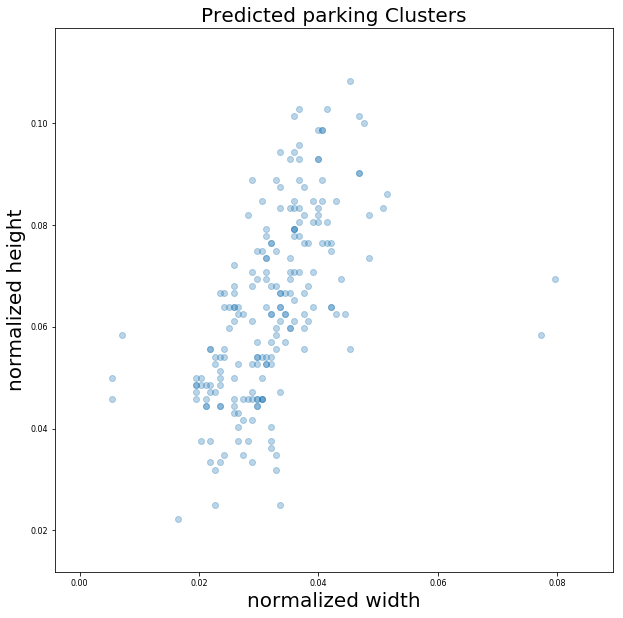

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(wh[:,0],wh[:,1],alpha=0.3)
plt.title("Predicted parking Clusters",fontsize=20)
plt.xlabel("normalized width",fontsize=20)
plt.ylabel("normalized height",fontsize=20)
plt.show()

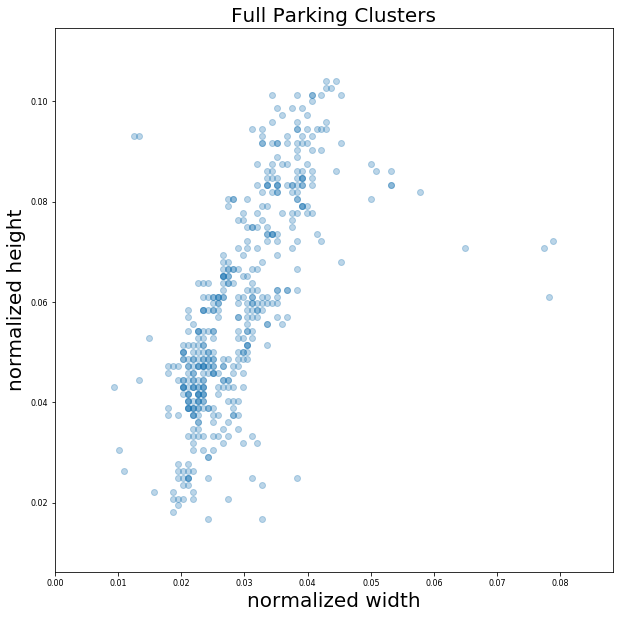

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(wh_fullpark[:,0],wh_fullpark[:,1],alpha=0.3)
plt.title("Full Parking Clusters",fontsize=20)
plt.xlabel("normalized width",fontsize=20)
plt.ylabel("normalized height",fontsize=20)
plt.show()

In [8]:
options = {
    'model': 'cfg/yolo.cfg',
    'load': 'yolo.weights',
    'threshold': 0.2,
    'gpu': 2.0
}
# Using DrawFlow model predict individual cropped slot contain Car or empty space
tfnet = TFNet(options)

Parsing ./cfg/yolo.cfg
Parsing cfg/yolo.cfg
Loading yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.09974145889282227s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | 

In [18]:
print(crop_images[235].shape)
print(crop_images[236].shape)
print(full_parking_boxes_cord[235])
print(full_parking_boxes_cord[236])

(65, 49, 3)
(54, 40, 3)
[1223, 408, 1272, 473]
[0, 498, 40, 552]


When introducing the use of K-means to cluster a priori bounding boxes, it is necessary to discuss the concept of iou, because we will use it later to measure the distance between two boundingboxes. Iou is a measure of the accuracy of detecting a corresponding object in a particular data set. We can see a lot of the use of this standard in many object detection challenges, such as the PASCAL VOC challenge. When we calculate the iou of two bounding boxes, we only need to use their four positional parameters (xmin, ymin, width, height), here is a reference to someone else:

In [27]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

### K-means clustering
K-means' clustering method is very simple, it mainly consists of two steps:

First initialize the category quantity and cluster center:

Step 1: Calculate the distance (1-iou) of each boundingbox from all cluster centers, and select the nearest cluster center as its category.
Step 2: Use the mean of each category cluster as the category center for the next iteration calculation
Repeat steps 1 and 2 until the center of each category no longer changes.

In [28]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

### Full Parking Cluster
In general, the more categories of anchor clusters, the more the yolo algorithm can regress with the real box at different scales, but this also increases the amount of computation. (This is extremely embarrassing for a real-time target detection framework, so the authors also try to reduce the number of boundingboxes).

In [51]:
kmax = 10
dist = np.mean
results_fullpark = {}

for k in range(1,kmax):
    clusters, nearest_clusters, distances = kmeans(wh_fullpark,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results_fullpark[k] = result

 1 clusters: mean IoU = 0.5001
 2 clusters: mean IoU = 0.7538
 3 clusters: mean IoU = 0.7991
 4 clusters: mean IoU = 0.8209
 5 clusters: mean IoU = 0.8276
 6 clusters: mean IoU = 0.8390
 7 clusters: mean IoU = 0.8513
 8 clusters: mean IoU = 0.8543
 9 clusters: mean IoU = 0.8634


In [50]:
kmax = 10
dist = np.mean
results = {}

for k in range(1,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 1 clusters: mean IoU = 0.6118
 2 clusters: mean IoU = 0.7630
 3 clusters: mean IoU = 0.7814
 4 clusters: mean IoU = 0.8112
 5 clusters: mean IoU = 0.8273
 6 clusters: mean IoU = 0.8327
 7 clusters: mean IoU = 0.8458
 8 clusters: mean IoU = 0.8488
 9 clusters: mean IoU = 0.8559


The more the number of categories, the larger the mean iou of each cluster, indicating that the boundingbox in the cluster is more closely attached. Sometimes it is difficult to determine the number of categories, which is also a big pain point for k-means! In the yolov2 paper, five a priori anchors are set, so let's first look at the effect of the number of clusters from 5 to 8.

In [55]:
import seaborn as sns

def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh,k):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters=%d" %k)
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  

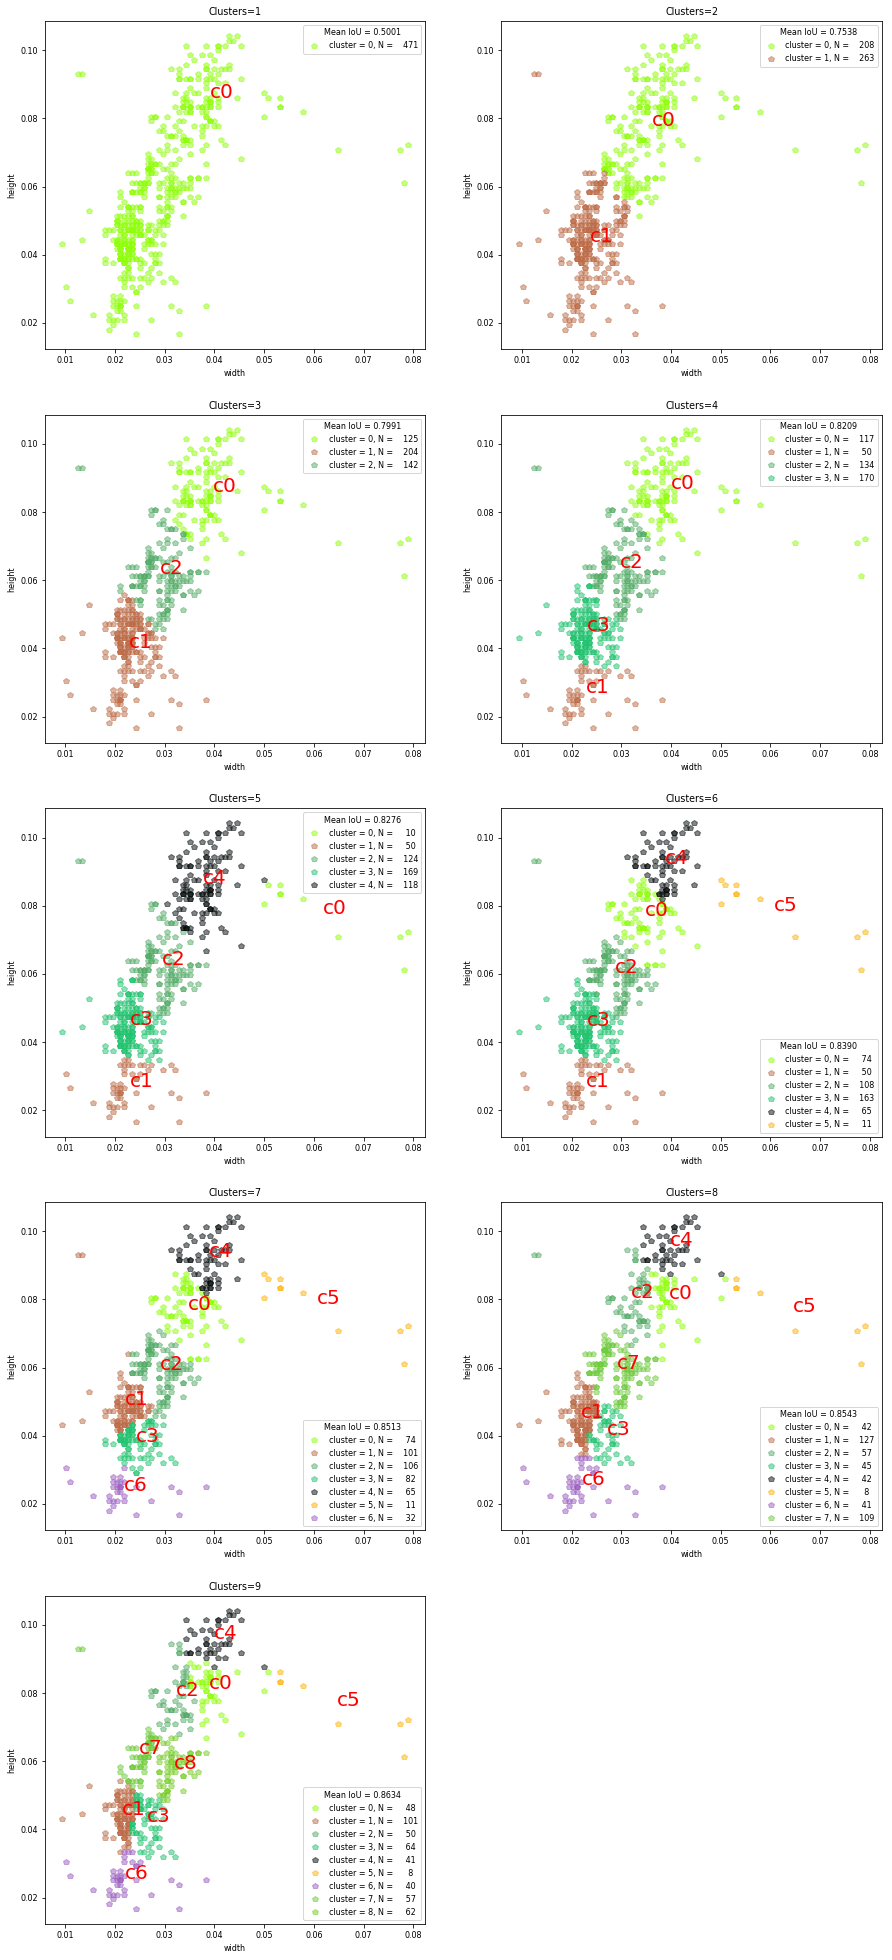

In [56]:
current_palette = list(sns.xkcd_rgb.values())
figsize = (15,35)
count =1
fig = plt.figure(figsize=figsize)
for k in range(1,10):
    result               = results_fullpark[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh_fullpark,k)
    count += 1
plt.show()

### Predicted Parking Cluster

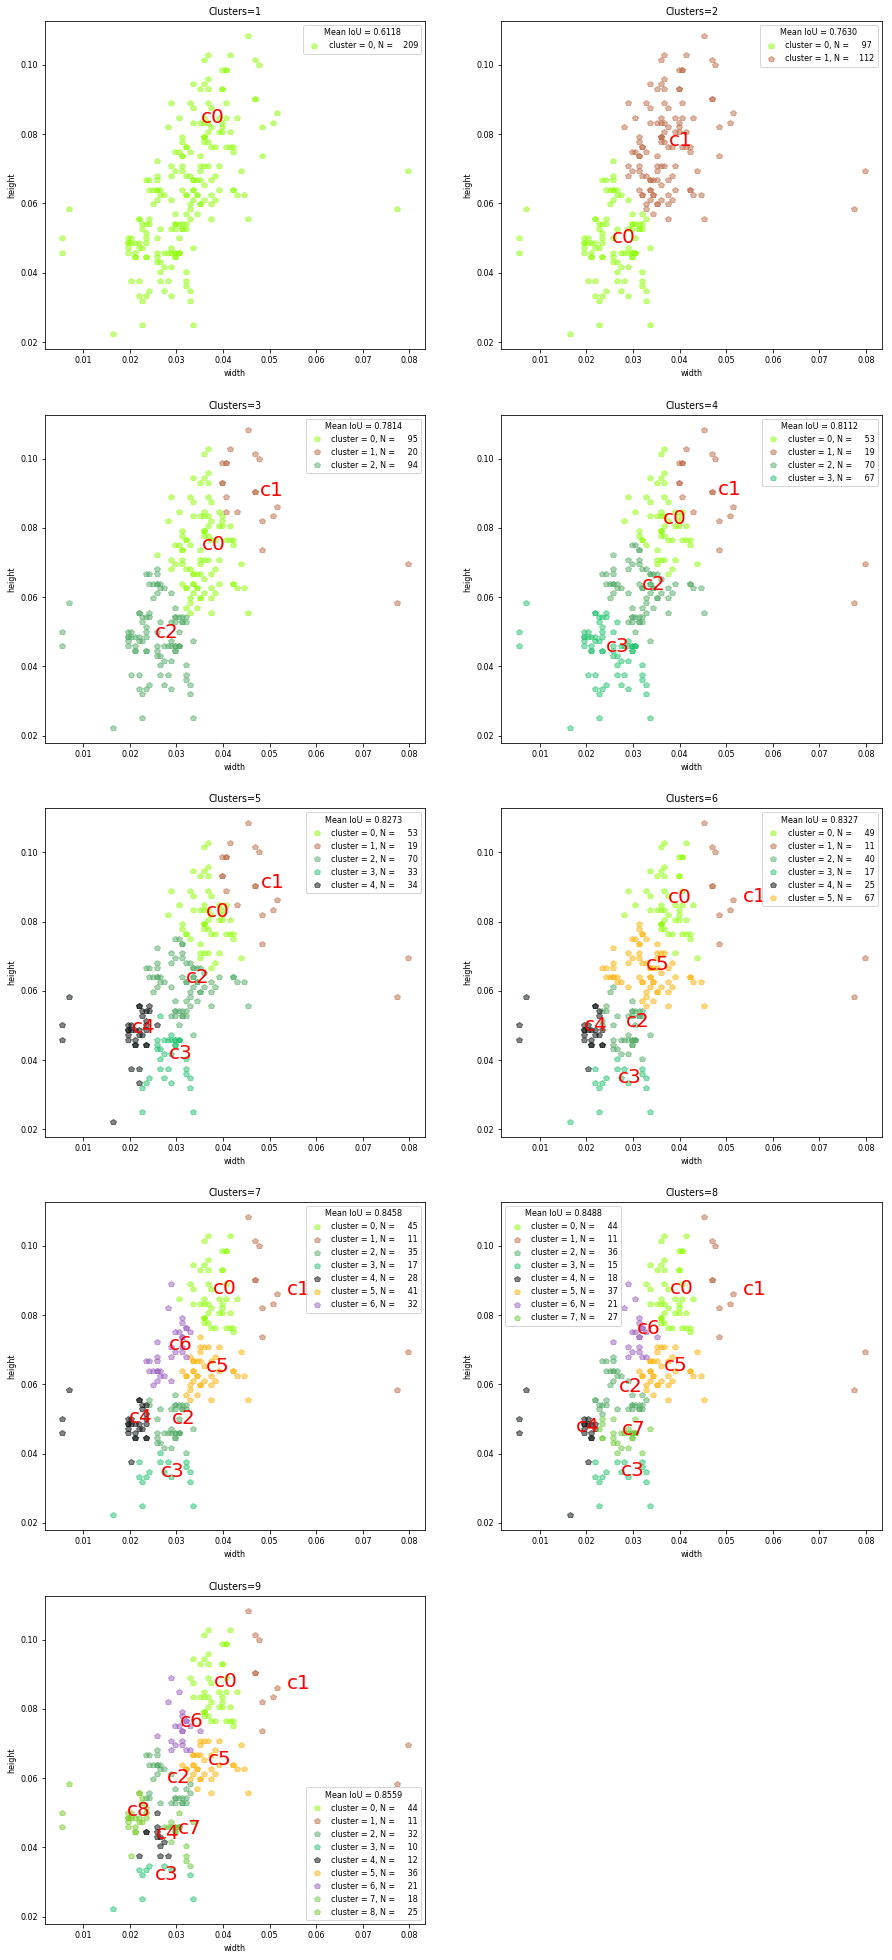

In [59]:
current_palette = list(sns.xkcd_rgb.values())
figsize = (15,35)
count =1
fig = plt.figure(figsize=figsize)
for k in range(1,10):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh,k)
    count += 1
plt.show()

In [20]:
Green_Box = []
Red_Box = []
for i in range(len(crop_images)):
    print(crop_images[i])
    print(i)
    print(len(crop_images[i]))
    if(len(crop_images[i]) >= 1):
        results = tfnet.return_predict(crop_images[i])
        for j in range(len(results)):
            if results[j]['label'] == 'car':
                Green_Box.append(full_parking_boxes_cord[i])

[[[122 132 132]
  [119 133 131]
  [117 131 129]
  ...
  [ 97 141 134]
  [102 132 127]
  [100 116 115]]

 [[120 129 133]
  [119 131 133]
  [117 129 131]
  ...
  [101 143 136]
  [101 131 126]
  [100 116 115]]

 [[118 126 133]
  [121 128 137]
  [119 127 134]
  ...
  [ 95 137 130]
  [ 97 126 123]
  [ 99 117 118]]

 ...

 [[ 71 129 105]
  [ 69 127 103]
  [ 68 124 101]
  ...
  [ 64 131 100]
  [ 65 129  99]
  [ 64 128  99]]

 [[ 76 134 110]
  [ 76 132 109]
  [ 70 124 101]
  ...
  [ 64 132 101]
  [ 63 130  99]
  [ 64 128  99]]

 [[ 76 132 109]
  [ 78 133 108]
  [ 73 128 103]
  ...
  [ 65 132 105]
  [ 65 130 104]
  [ 66 130 101]]]
0
51
[[[ 82 142 131]
  [ 83 143 133]
  [ 84 144 136]
  ...
  [ 72 133 119]
  [ 74 135 121]
  [ 72 133 119]]

 [[ 92 144 134]
  [ 93 144 136]
  [ 93 146 137]
  ...
  [ 77 134 125]
  [ 79 136 127]
  [ 76 134 123]]

 [[102 147 130]
  [101 146 130]
  [100 147 131]
  ...
  [ 82 133 125]
  [ 83 136 127]
  [ 84 137 127]]

 ...

 [[158 172 178]
  [155 166 170]
  [163 172 176]

  [132 135 140]]]
12
18
[[[129 136 139]
  [131 138 141]
  [132 140 140]
  ...
  [ 98 161 141]
  [ 96 154 136]
  [ 96 150 133]]

 [[130 136 141]
  [130 139 143]
  [131 140 143]
  ...
  [ 95 164 143]
  [ 94 157 137]
  [ 98 154 135]]

 [[130 136 141]
  [130 139 143]
  [131 140 144]
  ...
  [ 94 163 142]
  [ 98 163 141]
  [108 165 144]]

 ...

 [[141 153 157]
  [140 155 158]
  [137 154 157]
  ...
  [161 154 145]
  [160 151 141]
  [158 152 139]]

 [[143 156 158]
  [142 157 160]
  [139 156 159]
  ...
  [161 154 145]
  [161 152 143]
  [151 145 132]]

 [[139 157 158]
  [139 159 160]
  [137 158 159]
  ...
  [158 151 142]
  [157 148 139]
  [149 141 128]]]
13
23
[[[116 134 145]
  [105 121 134]
  [114 130 143]
  ...
  [158 151 132]
  [153 143 125]
  [153 140 124]]

 [[110 129 137]
  [111 125 137]
  [117 134 143]
  ...
  [147 143 125]
  [148 141 126]
  [150 141 128]]

 [[104 121 130]
  [110 125 134]
  [124 140 147]
  ...
  [145 144 130]
  [147 146 132]
  [141 137 126]]

 ...

 [[ 80  92  94]
  [ 73

  [189 191 191]]]
25
23
[[[156 160 165]
  [155 159 164]
  [156 160 165]
  ...
  [160 173 171]
  [158 171 169]
  [155 167 167]]

 [[157 161 166]
  [157 161 166]
  [159 163 168]
  ...
  [139 150 148]
  [139 150 148]
  [138 149 147]]

 [[161 164 168]
  [163 166 170]
  [164 167 171]
  ...
  [144 150 149]
  [147 154 151]
  [149 154 152]]

 ...

 [[168 172 173]
  [168 173 174]
  [167 177 177]
  ...
  [237 233 222]
  [232 227 212]
  [217 212 191]]

 [[170 176 175]
  [169 177 176]
  [165 179 178]
  ...
  [236 230 217]
  [219 212 195]
  [195 191 167]]

 [[173 181 180]
  [169 182 180]
  [164 182 181]
  ...
  [219 214 199]
  [200 196 177]
  [162 162 138]]]
26
26
[[[134 143 147]
  [142 151 155]
  [148 158 165]
  ...
  [175 176 172]
  [177 178 174]
  [180 181 177]]

 [[136 147 151]
  [147 158 162]
  [154 167 169]
  ...
  [175 176 172]
  [177 178 174]
  [179 180 176]]

 [[150 162 164]
  [157 169 171]
  [158 172 171]
  ...
  [173 177 172]
  [174 178 173]
  [174 180 175]]

 ...

 [[180 168 174]
  [173

  [248 226 231]]]
38
44
[[[139 146 173]
  [140 147 180]
  [143 152 186]
  ...
  [181 187 186]
  [180 186 185]
  [179 185 184]]

 [[149 156 183]
  [145 154 188]
  [145 154 191]
  ...
  [180 186 185]
  [178 183 184]
  [177 183 182]]

 [[148 159 186]
  [140 152 186]
  [134 147 185]
  ...
  [177 185 185]
  [178 183 186]
  [178 183 184]]

 ...

 [[185 192 195]
  [182 188 193]
  [180 183 191]
  ...
  [ 95 107 109]
  [ 98 106 106]
  [ 97 103 102]]

 [[196 203 200]
  [198 203 204]
  [200 203 207]
  ...
  [164 170 165]
  [168 170 164]
  [167 164 159]]

 [[196 205 202]
  [204 210 209]
  [208 213 214]
  ...
  [184 191 184]
  [183 184 175]
  [176 173 165]]]
39
34
[[[230 226 225]
  [224 222 222]
  [208 206 206]
  ...
  [214 212 218]
  [193 197 198]
  [183 191 190]]

 [[229 228 224]
  [222 220 219]
  [205 206 204]
  ...
  [218 210 220]
  [191 195 196]
  [181 192 190]]

 [[225 225 225]
  [211 213 213]
  [195 200 199]
  ...
  [208 199 209]
  [178 182 183]
  [175 186 184]]

 ...

 [[225 225 213]
  [163

  [145 142 138]]]
51
35
[[[ 85 167 145]
  [ 88 165 144]
  [ 90 165 144]
  ...
  [174 166 167]
  [255 248 250]
  [255 254 254]]

 [[ 87 167 144]
  [ 87 165 142]
  [ 88 163 142]
  ...
  [157 142 146]
  [209 194 198]
  [239 231 232]]

 [[ 85 166 141]
  [ 86 164 140]
  [ 88 163 141]
  ...
  [147 129 136]
  [177 163 169]
  [206 199 202]]

 ...

 [[ 90 135 149]
  [102 151 165]
  [109 164 173]
  ...
  [151 150 146]
  [149 150 146]
  [148 149 145]]

 [[ 78 123 137]
  [ 91 140 154]
  [100 156 167]
  ...
  [152 151 147]
  [149 150 146]
  [148 149 145]]

 [[ 90 136 153]
  [ 94 147 160]
  [ 99 160 170]
  ...
  [152 151 147]
  [150 151 147]
  [148 149 145]]]
52
34
[[[172 185 171]
  [125 137 125]
  [102 109 104]
  ...
  [193 201 200]
  [192 203 200]
  [190 201 198]]

 [[114 125 115]
  [ 95 108 100]
  [114 122 121]
  ...
  [189 202 200]
  [187 201 199]
  [187 200 198]]

 [[ 95 105  99]
  [108 119 117]
  [135 144 148]
  ...
  [185 197 197]
  [184 198 197]
  [186 199 197]]

 ...

 [[191 208 211]
  [190

  [251 254 255]]]
64
46
[[[206 204 203]
  [209 207 206]
  [207 208 206]
  ...
  [208 215 202]
  [202 211 198]
  [200 208 201]]

 [[208 206 205]
  [208 206 205]
  [206 207 205]
  ...
  [207 211 199]
  [204 210 199]
  [199 206 199]]

 [[204 205 203]
  [202 203 201]
  [203 203 203]
  ...
  [164 162 151]
  [190 188 177]
  [210 208 200]]

 ...

 [[210 200 190]
  [169 160 150]
  [114 107  98]
  ...
  [118 156 156]
  [121 159 159]
  [121 159 161]]

 [[162 158 147]
  [113 108  99]
  [ 70  62  55]
  ...
  [109 155 163]
  [111 157 165]
  [107 153 164]]

 [[113 109  98]
  [ 70  68  58]
  [ 52  46  41]
  ...
  [104 152 164]
  [103 151 163]
  [ 98 145 159]]]
65
36
[[[201 202 198]
  [204 205 201]
  [204 205 201]
  ...
  [196 205 195]
  [196 204 197]
  [195 203 196]]

 [[200 201 197]
  [202 206 201]
  [203 204 200]
  ...
  [193 201 191]
  [192 200 193]
  [193 201 194]]

 [[197 201 195]
  [198 205 198]
  [203 207 202]
  ...
  [195 200 191]
  [192 199 192]
  [193 200 193]]

 ...

 [[251 254 252]
  [251

  [102 147 150]]]
77
39
[[[171 188 191]
  [170 187 190]
  [169 186 189]
  ...
  [168 181 183]
  [168 181 183]
  [167 180 182]]

 [[175 187 187]
  [173 186 188]
  [167 184 187]
  ...
  [167 181 180]
  [168 183 179]
  [164 181 177]]

 [[173 183 183]
  [170 182 184]
  [166 181 184]
  ...
  [165 179 178]
  [165 180 176]
  [162 179 175]]

 ...

 [[222 219 228]
  [194 193 202]
  [184 187 192]
  ...
  [239 233 234]
  [219 214 215]
  [194 192 192]]

 [[215 213 219]
  [188 188 194]
  [181 184 188]
  ...
  [225 222 224]
  [203 202 204]
  [184 186 186]]

 [[201 196 197]
  [188 188 188]
  [184 186 186]
  ...
  [221 222 226]
  [194 199 202]
  [184 189 190]]]
78
48
[[[175 191 190]
  [176 191 193]
  [176 192 191]
  ...
  [191 201 201]
  [192 202 202]
  [190 202 202]]

 [[177 192 194]
  [177 192 195]
  [177 192 194]
  ...
  [193 203 203]
  [195 205 205]
  [193 205 205]]

 [[178 193 196]
  [180 194 200]
  [181 196 199]
  ...
  [193 204 202]
  [194 205 203]
  [193 206 204]]

 ...

 [[127 178 171]
  [128

  [216 193 215]]]
90
37
[[[149 157 156]
  [151 156 157]
  [151 156 157]
  ...
  [ 67  61  56]
  [ 75  69  64]
  [ 81  74  71]]

 [[149 157 157]
  [151 156 157]
  [151 156 157]
  ...
  [ 61  55  50]
  [ 66  60  55]
  [ 71  62  59]]

 [[150 155 156]
  [150 155 156]
  [148 156 156]
  ...
  [ 61  55  48]
  [ 61  55  48]
  [ 61  55  50]]

 ...

 [[247 232 230]
  [255 252 250]
  [255 253 249]
  ...
  [145 154 151]
  [146 155 152]
  [147 156 153]]

 [[222 205 202]
  [225 210 207]
  [225 212 204]
  ...
  [144 153 150]
  [147 154 151]
  [147 156 153]]

 [[249 234 231]
  [232 218 212]
  [203 191 181]
  ...
  [149 156 153]
  [150 155 153]
  [151 158 153]]]
91
45
[[[155 163 163]
  [154 162 162]
  [154 162 161]
  ...
  [110 105 102]
  [109 104 101]
  [110 105 104]]

 [[154 162 162]
  [154 162 162]
  [153 161 160]
  ...
  [106 101  98]
  [106 101  98]
  [105 100  99]]

 [[154 162 162]
  [153 161 161]
  [151 159 158]
  ...
  [ 96  89  86]
  [ 94  87  84]
  [ 90  82  82]]

 ...

 [[255 255 251]
  [255

  [127 130 134]]]
104
40
[[[ 61  75  74]
  [ 57  75  74]
  [ 56  77  74]
  ...
  [ 45  56  54]
  [ 50  61  58]
  [ 52  66  62]]

 [[ 62  75  77]
  [ 60  76  75]
  [ 59  77  76]
  ...
  [ 45  56  54]
  [ 51  62  60]
  [ 53  67  63]]

 [[ 63  75  77]
  [ 63  76  78]
  [ 64  77  79]
  ...
  [ 43  54  52]
  [ 48  61  59]
  [ 54  67  65]]

 ...

 [[ 88  87  89]
  [ 91  92  96]
  [ 97  98 102]
  ...
  [ 56  67  65]
  [ 54  68  64]
  [ 52  68  61]]

 [[ 84  85  89]
  [ 87  88  92]
  [ 96  97 101]
  ...
  [ 55  65  65]
  [ 55  69  65]
  [ 54  70  63]]

 [[ 83  84  88]
  [ 86  87  91]
  [ 94  97 101]
  ...
  [ 57  65  65]
  [ 57  68  65]
  [ 57  71  67]]]
105
45
[[[ 43  78  64]
  [ 46  81  67]
  [ 48  78  65]
  ...
  [ 47  63  52]
  [ 47  63  52]
  [ 48  62  50]]

 [[ 50  80  69]
  [ 52  84  73]
  [ 55  82  72]
  ...
  [ 49  62  54]
  [ 50  63  55]
  [ 52  63  53]]

 [[ 54  80  74]
  [ 54  81  72]
  [ 53  77  69]
  ...
  [ 45  57  51]
  [ 48  60  54]
  [ 51  63  57]]

 ...

 [[ 86  84  90]
  [ 

  [189 182 179]]]
130
47
[[[179 191 191]
  [180 193 191]
  [180 193 191]
  ...
  [179 187 186]
  [180 188 187]
  [180 188 187]]

 [[182 192 192]
  [184 192 191]
  [182 193 191]
  ...
  [180 188 187]
  [180 188 187]
  [180 188 187]]

 [[184 192 191]
  [186 192 191]
  [185 193 192]
  ...
  [180 188 187]
  [180 188 187]
  [181 186 187]]

 ...

 [[244 242 248]
  [255 245 251]
  [216 206 212]
  ...
  [247 254 255]
  [245 244 246]
  [242 238 237]]

 [[255 247 254]
  [251 236 244]
  [208 198 204]
  ...
  [248 255 255]
  [240 240 240]
  [241 238 234]]

 [[245 234 242]
  [225 212 220]
  [195 188 193]
  ...
  [251 255 255]
  [235 233 232]
  [241 237 232]]]
131
43
[[[171 189 188]
  [173 189 188]
  [172 188 187]
  ...
  [172 184 184]
  [174 184 184]
  [174 184 184]]

 [[173 189 188]
  [176 190 189]
  [176 190 189]
  ...
  [173 185 185]
  [172 184 184]
  [172 184 184]]

 [[175 189 188]
  [175 189 188]
  [176 190 189]
  ...
  [173 185 185]
  [173 185 185]
  [173 185 185]]

 ...

 [[140 140 146]
  [1

  [147 146 148]]]
143
42
[[[159 166 169]
  [158 165 168]
  [158 166 166]
  ...
  [153 165 165]
  [156 164 163]
  [159 165 164]]

 [[157 166 169]
  [157 166 169]
  [156 166 166]
  ...
  [153 165 165]
  [156 164 163]
  [157 165 164]]

 [[158 167 170]
  [157 167 167]
  [158 169 167]
  ...
  [155 165 165]
  [155 166 164]
  [155 166 164]]

 ...

 [[142 153 151]
  [145 156 153]
  [150 156 155]
  ...
  [194 183 203]
  [144 149 164]
  [140 152 162]]

 [[145 157 151]
  [146 158 152]
  [152 160 159]
  ...
  [196 185 211]
  [146 153 170]
  [136 152 164]]

 [[147 160 152]
  [145 159 153]
  [149 160 158]
  ...
  [198 189 216]
  [148 158 176]
  [133 151 162]]]
144
48
[[[158 170 170]
  [158 171 169]
  [156 169 167]
  ...
  [155 167 167]
  [155 168 166]
  [155 169 168]]

 [[159 171 173]
  [158 170 172]
  [156 169 171]
  ...
  [154 166 168]
  [154 166 166]
  [154 167 169]]

 [[159 170 174]
  [159 170 174]
  [158 169 173]
  ...
  [155 167 169]
  [154 167 169]
  [154 167 169]]

 ...

 [[145 156 153]
  [1

  [166 182 189]]]
156
45
[[[185 202 198]
  [192 207 203]
  [191 202 199]
  ...
  [253 255 255]
  [252 254 254]
  [250 253 251]]

 [[180 199 196]
  [188 203 199]
  [190 201 198]
  ...
  [253 252 254]
  [253 253 253]
  [253 254 250]]

 [[184 196 198]
  [187 197 197]
  [191 196 197]
  ...
  [255 255 255]
  [255 254 253]
  [255 252 251]]

 ...

 [[180 188 187]
  [179 187 186]
  [170 179 176]
  ...
  [238 230 231]
  [238 233 232]
  [224 225 221]]

 [[181 189 188]
  [181 189 188]
  [176 185 182]
  ...
  [247 233 235]
  [235 224 226]
  [215 216 214]]

 [[188 194 193]
  [190 196 195]
  [198 204 203]
  ...
  [246 231 235]
  [228 217 219]
  [206 207 205]]]
157
53
[[[156 180 178]
  [157 184 181]
  [166 188 186]
  ...
  [150 154 159]
  [150 154 159]
  [152 156 161]]

 [[127 167 162]
  [135 176 171]
  [136 176 171]
  ...
  [119 120 124]
  [123 125 126]
  [126 128 129]]

 [[122 171 163]
  [119 172 163]
  [114 166 159]
  ...
  [ 77  82  85]
  [ 80  85  86]
  [ 86  91  90]]

 ...

 [[178 189 187]
  [1

  [141 156 158]]]
169
60
[[[ 60  62  80]
  [ 98 105 124]
  [106 115 125]
  ...
  [163 181 182]
  [161 179 180]
  [158 177 180]]

 [[ 55  57  65]
  [ 60  67  76]
  [ 59  68  72]
  ...
  [164 182 183]
  [159 178 181]
  [157 176 181]]

 [[ 57  56  58]
  [ 54  59  62]
  [ 49  53  58]
  ...
  [162 180 181]
  [157 176 179]
  [153 173 178]]

 ...

 [[232 224 234]
  [255 251 255]
  [248 240 250]
  ...
  [180 188 201]
  [221 221 233]
  [240 235 244]]

 [[210 205 206]
  [234 227 230]
  [212 210 216]
  ...
  [187 193 204]
  [215 217 227]
  [218 218 224]]

 [[183 184 182]
  [190 190 190]
  [183 186 191]
  ...
  [175 182 191]
  [185 190 199]
  [190 194 199]]]
170
56
[[[162 182 183]
  [164 184 185]
  [166 187 185]
  ...
  [167 187 182]
  [167 187 182]
  [166 188 183]]

 [[158 182 180]
  [163 185 183]
  [164 186 184]
  ...
  [168 187 184]
  [166 187 184]
  [165 188 184]]

 [[155 182 178]
  [159 185 179]
  [159 184 180]
  ...
  [163 181 182]
  [161 181 182]
  [160 182 180]]

 ...

 [[188 192 186]
  [1

  [109 123 117]]]
182
59
[[[174 156 139]
  [170 154 137]
  [171 157 139]
  ...
  [ 56  49  46]
  [ 57  49  49]
  [ 66  56  56]]

 [[166 151 135]
  [163 147 134]
  [166 152 140]
  ...
  [ 79  71  64]
  [ 63  54  51]
  [ 64  52  50]]

 [[189 180 171]
  [165 153 147]
  [144 130 131]
  ...
  [101  94  85]
  [ 76  65  61]
  [ 56  45  41]]

 ...

 [[ 68  77  81]
  [ 48  51  56]
  [ 28  27  29]
  ...
  [134 139 154]
  [127 133 140]
  [132 139 142]]

 [[ 78  87  90]
  [ 63  63  69]
  [ 40  39  43]
  ...
  [155 154 170]
  [134 139 148]
  [132 143 147]]

 [[ 85  94  98]
  [ 68  71  76]
  [ 51  52  56]
  ...
  [170 165 186]
  [133 139 150]
  [127 141 147]]]
183
53
[[[175 156 143]
  [169 153 137]
  [174 159 143]
  ...
  [ 75  67  67]
  [ 90  78  76]
  [ 94  84  77]]

 [[181 160 145]
  [174 155 140]
  [175 159 143]
  ...
  [ 72  64  64]
  [ 84  72  70]
  [ 87  77  70]]

 [[175 155 138]
  [174 156 139]
  [170 154 137]
  ...
  [ 66  56  56]
  [ 71  58  56]
  [ 73  61  55]]

 ...

 [[ 86 104 111]
  [ 

  [164 181 184]]]
195
57
[[[188 199 196]
  [187 198 195]
  [187 198 195]
  ...
  [193 202 199]
  [191 202 199]
  [190 201 198]]

 [[189 200 197]
  [189 200 197]
  [187 201 197]
  ...
  [192 203 200]
  [192 203 200]
  [191 202 199]]

 [[188 201 199]
  [188 201 199]
  [188 202 198]
  ...
  [192 203 200]
  [191 202 199]
  [188 202 198]]

 ...

 [[166 165 169]
  [146 138 139]
  [132 120 118]
  ...
  [154 173 178]
  [159 178 183]
  [164 183 188]]

 [[124 119 120]
  [115 108 105]
  [108  97  93]
  ...
  [147 161 173]
  [152 168 180]
  [160 178 185]]

 [[ 93  88  87]
  [ 79  72  69]
  [ 75  66  62]
  ...
  [135 148 162]
  [146 162 174]
  [156 174 181]]]
196
60
[[[192 200 199]
  [197 205 205]
  [196 206 206]
  ...
  [193 208 204]
  [193 207 203]
  [193 207 203]]

 [[204 213 217]
  [207 213 220]
  [207 213 218]
  ...
  [194 208 206]
  [195 208 206]
  [194 207 205]]

 [[175 181 186]
  [193 197 202]
  [204 209 212]
  ...
  [195 209 208]
  [194 207 205]
  [195 208 206]]

 ...

 [[119 141 147]
  [1

  [ 82 105 120]]]
208
62
[[[176 192 191]
  [178 191 193]
  [176 188 188]
  ...
  [172 189 186]
  [177 191 189]
  [177 191 190]]

 [[178 188 195]
  [181 190 194]
  [180 189 192]
  ...
  [167 187 182]
  [171 188 184]
  [171 188 185]]

 [[183 192 196]
  [185 191 196]
  [184 191 194]
  ...
  [167 187 182]
  [164 184 179]
  [165 181 180]]

 ...

 [[ 91 103 113]
  [127 128 154]
  [201 192 225]
  ...
  [159 142 151]
  [190 169 178]
  [172 150 155]]

 [[ 91 107 119]
  [126 133 153]
  [177 174 199]
  ...
  [170 153 164]
  [201 176 186]
  [162 137 141]]

 [[ 82 105 120]
  [100 119 140]
  [123 134 156]
  ...
  [172 162 175]
  [183 166 177]
  [136 119 122]]]
209
59
[[[176 188 188]
  [175 188 186]
  [174 187 185]
  ...
  [171 188 185]
  [172 189 186]
  [177 191 189]]

 [[180 189 192]
  [177 188 186]
  [172 183 180]
  ...
  [168 188 183]
  [167 187 182]
  [171 188 184]]

 [[184 191 194]
  [184 192 191]
  [179 188 185]
  ...
  [169 189 184]
  [167 187 182]
  [164 184 179]]

 ...

 [[177 174 199]
  [2

  [114 110 105]]]
221
57
[[[165 180 176]
  [165 178 176]
  [165 178 176]
  ...
  [155 177 182]
  [156 177 179]
  [156 175 178]]

 [[165 180 176]
  [166 179 177]
  [165 179 177]
  ...
  [156 178 183]
  [156 178 183]
  [158 177 180]]

 [[167 182 178]
  [167 181 179]
  [167 181 179]
  ...
  [158 180 185]
  [158 180 185]
  [159 178 181]]

 ...

 [[131 154 156]
  [130 153 155]
  [128 149 151]
  ...
  [187 188 192]
  [191 190 194]
  [186 185 187]]

 [[122 151 156]
  [124 153 158]
  [126 152 158]
  ...
  [177 170 175]
  [183 176 181]
  [194 190 196]]

 [[124 155 156]
  [131 161 162]
  [137 167 168]
  ...
  [ 98  91  94]
  [103  97 102]
  [106 104 110]]]
222
66
[[[158 168 162]
  [159 169 163]
  [160 170 164]
  ...
  [153 167 161]
  [153 167 163]
  [151 166 162]]

 [[156 163 160]
  [162 169 164]
  [163 170 165]
  ...
  [154 165 162]
  [152 165 163]
  [151 165 163]]

 [[160 167 164]
  [163 170 165]
  [161 168 163]
  ...
  [153 164 161]
  [153 166 164]
  [153 167 165]]

 ...

 [[112 111 107]
  [1

  [ 84  91 106]]]
234
59
[[[112 119 122]
  [106 112 117]
  [100 106 111]
  ...
  [ 43  43  43]
  [ 42  40  40]
  [ 59  64  62]]

 [[114 121 124]
  [106 112 117]
  [102 108 113]
  ...
  [ 20  19  21]
  [ 26  24  24]
  [ 42  45  43]]

 [[111 116 119]
  [109 113 118]
  [106 110 115]
  ...
  [ 40  35  37]
  [ 36  30  31]
  [ 39  37  37]]

 ...

 [[113 115 125]
  [109 113 124]
  [107 113 124]
  ...
  [ 90  98 105]
  [ 90  97 106]
  [ 91  98 107]]

 [[112 114 124]
  [111 115 126]
  [109 115 126]
  ...
  [ 89  97 104]
  [ 90  98 105]
  [ 93  98 107]]

 [[114 117 125]
  [111 116 125]
  [111 116 125]
  ...
  [ 91  97 102]
  [ 92  98 103]
  [ 93  99 106]]]
235
65
[[[ 68 123  96]
  [ 67 124  99]
  [ 67 125 101]
  ...
  [ 76 148 135]
  [ 78 148 135]
  [ 78 148 135]]

 [[ 70 125 100]
  [ 69 126 101]
  [ 69 125 104]
  ...
  [ 78 150 138]
  [ 81 150 139]
  [ 81 150 139]]

 [[ 73 127 104]
  [ 71 127 104]
  [ 72 128 107]
  ...
  [ 80 152 140]
  [ 80 152 139]
  [ 80 152 139]]

 ...

 [[182 184 195]
  [2

  [153 168 177]]]
247
72
[[[ 57 124  97]
  [ 58 125  98]
  [ 60 127 100]
  ...
  [ 65 129  99]
  [ 66 130 100]
  [ 66 130 100]]

 [[ 57 124  97]
  [ 57 126  99]
  [ 58 127 100]
  ...
  [ 61 129  98]
  [ 65 133 102]
  [ 68 136 105]]

 [[ 54 124  94]
  [ 57 127  97]
  [ 57 127  97]
  ...
  [ 58 131  99]
  [ 65 138 106]
  [ 71 141 110]]

 ...

 [[159 174 183]
  [159 177 184]
  [158 176 183]
  ...
  [158 169 177]
  [159 170 178]
  [157 173 179]]

 [[170 187 196]
  [169 188 193]
  [168 184 190]
  ...
  [158 170 176]
  [160 174 180]
  [159 178 183]]

 [[170 191 199]
  [170 189 197]
  [163 181 188]
  ...
  [147 166 171]
  [157 176 183]
  [156 180 186]]]
248
73
[[[ 59 126  97]
  [ 59 126  97]
  [ 59 126  97]
  ...
  [ 60 119  91]
  [ 60 119  91]
  [ 61 119  91]]

 [[ 58 124  95]
  [ 56 123  94]
  [ 56 122  93]
  ...
  [ 62 121  93]
  [ 61 120  92]
  [ 61 120  92]]

 [[ 58 122  93]
  [ 56 122  93]
  [ 58 122  93]
  ...
  [ 60 122  92]
  [ 60 122  92]
  [ 61 123  93]]

 ...

 [[147 166 173]
  [1

  [ 83 118 104]]]
260
73
[[[ 54  99  82]
  [ 54  99  82]
  [ 55 100  83]
  ...
  [ 56  95  79]
  [ 59  95  78]
  [ 60  94  77]]

 [[ 52 103  83]
  [ 55 104  84]
  [ 55 106  86]
  ...
  [ 57 104  88]
  [ 59 102  87]
  [ 58 100  83]]

 [[ 49 107  83]
  [ 51 107  84]
  [ 52 108  85]
  ...
  [ 59 111  93]
  [ 58 108  90]
  [ 55 105  87]]

 ...

 [[ 63 109  96]
  [ 69 113 100]
  [ 71 114 101]
  ...
  [ 83 136 127]
  [ 92 145 136]
  [ 89 140 133]]

 [[ 70 113  98]
  [ 72 113  98]
  [ 74 112 100]
  ...
  [ 95 148 139]
  [ 93 145 138]
  [ 81 131 127]]

 [[ 78 123 104]
  [ 74 116  99]
  [ 76 115 100]
  ...
  [ 98 149 142]
  [ 91 141 137]
  [ 80 126 127]]]
261
73
[[[ 65 123  95]
  [ 64 120  97]
  [ 63 115  97]
  ...
  [ 71 124 110]
  [ 70 123 109]
  [ 64 115 101]]

 [[ 67 125  97]
  [ 68 124 101]
  [ 69 125 104]
  ...
  [ 74 127 113]
  [ 70 121 107]
  [ 68 117 103]]

 [[ 68 131 105]
  [ 71 133 109]
  [ 74 136 112]
  ...
  [ 66 122 103]
  [ 70 126 107]
  [ 67 123 102]]

 ...

 [[105 151 139]
  [1

  [ 63 116  89]]]
273
70
[[[ 98 147 127]
  [ 92 141 119]
  [ 93 140 118]
  ...
  [ 79 108  99]
  [ 82 108 102]
  [ 85 108 103]]

 [[ 99 146 124]
  [ 89 136 114]
  [ 88 134 112]
  ...
  [ 91 114 109]
  [ 81 104 100]
  [ 69  90  88]]

 [[105 148 127]
  [ 95 138 117]
  [ 94 137 116]
  ...
  [107 130 126]
  [ 91 112 110]
  [ 65  85  86]]

 ...

 [[110 141 134]
  [104 135 128]
  [100 129 120]
  ...
  [ 61 107  84]
  [ 64 112  88]
  [ 63 115  91]]

 [[104 135 126]
  [103 130 121]
  [102 125 117]
  ...
  [ 62 113  86]
  [ 65 116  89]
  [ 69 120  93]]

 [[104 134 123]
  [106 130 122]
  [111 130 121]
  ...
  [ 63 114  87]
  [ 65 116  89]
  [ 72 120  94]]]
274
71
[[[ 84 121 111]
  [ 82 118 106]
  [ 90 124 113]
  ...
  [ 43  86  71]
  [ 57 102  85]
  [ 68 117  95]]

 [[ 98 130 119]
  [ 89 118 109]
  [ 88 117 108]
  ...
  [ 46  90  73]
  [ 57 104  82]
  [ 65 115  91]]

 [[111 141 130]
  [109 136 127]
  [111 137 131]
  ...
  [ 52  98  76]
  [ 61 109  85]
  [ 65 118  91]]

 ...

 [[ 50  94  71]
  [ 

  [111  97 115]]]
286
12
[[[118 120 121]
  [118 120 121]
  [118 120 120]
  ...
  [113 126 128]
  [113 126 128]
  [115 127 129]]

 [[122 121 123]
  [120 122 123]
  [120 122 123]
  ...
  [116 127 131]
  [116 127 131]
  [116 127 131]]

 [[124 123 125]
  [122 124 125]
  [122 124 125]
  ...
  [117 128 132]
  [117 128 132]
  [119 128 132]]

 ...

 [[122 130 137]
  [122 134 136]
  [124 137 139]
  ...
  [132 141 144]
  [133 142 146]
  [133 141 148]]

 [[126 134 141]
  [125 136 140]
  [127 140 142]
  ...
  [128 141 143]
  [129 141 145]
  [129 141 145]]

 [[129 137 144]
  [127 138 142]
  [128 140 144]
  ...
  [126 142 141]
  [124 142 143]
  [124 142 143]]]
287
20
[[[113 124 121]
  [112 126 122]
  [114 127 125]
  ...
  [120 129 133]
  [120 129 133]
  [119 128 132]]

 [[118 126 125]
  [117 128 126]
  [118 128 128]
  ...
  [121 130 133]
  [120 129 132]
  [120 129 132]]

 [[119 127 126]
  [119 127 126]
  [118 128 128]
  ...
  [120 129 132]
  [120 129 132]
  [120 129 132]]

 ...

 [[145 144 160]
  [1

  [122 134 136]]]
299
16
[[[134 144 151]
  [133 145 151]
  [136 148 154]
  ...
  [128 145 141]
  [130 144 142]
  [130 144 142]]

 [[133 144 152]
  [133 144 152]
  [136 145 154]
  ...
  [128 145 142]
  [129 143 141]
  [129 143 141]]

 [[131 145 151]
  [134 145 153]
  [138 145 154]
  ...
  [128 145 142]
  [129 143 141]
  [128 142 140]]

 ...

 [[130 130 136]
  [156 148 159]
  [188 174 192]
  ...
  [108 117 127]
  [108 118 128]
  [111 124 132]]

 [[133 133 145]
  [165 157 174]
  [203 192 212]
  ...
  [108 118 128]
  [109 120 128]
  [112 125 133]]

 [[142 146 165]
  [169 169 193]
  [206 206 224]
  ...
  [103 123 128]
  [107 124 127]
  [114 129 132]]]
300
16
[[[130 142 142]
  [130 140 140]
  [133 141 141]
  ...
  [118 127 131]
  [115 126 130]
  [112 127 130]]

 [[129 141 141]
  [130 140 140]
  [130 140 140]
  ...
  [116 127 131]
  [114 126 130]
  [115 128 130]]

 [[131 141 141]
  [129 141 141]
  [129 141 141]
  ...
  [115 127 131]
  [114 127 129]
  [115 128 130]]

 ...

 [[110 126 133]
  [1

  [ 71 117 111]]]
305
15
[[[122 152 157]
  [122 151 158]
  [121 148 152]
  ...
  [254 252 255]
  [232 240 247]
  [116 136 141]]

 [[126 155 159]
  [131 160 165]
  [130 155 159]
  ...
  [255 253 255]
  [244 251 255]
  [160 176 183]]

 [[131 156 158]
  [132 159 163]
  [125 149 149]
  ...
  [254 251 255]
  [249 251 255]
  [195 204 213]]

 ...

 [[163 174 194]
  [179 191 215]
  [159 176 197]
  ...
  [254 255 253]
  [255 254 255]
  [255 254 255]]

 [[145 160 169]
  [152 171 179]
  [145 168 176]
  ...
  [250 255 248]
  [252 254 248]
  [255 255 251]]

 [[139 156 159]
  [144 165 167]
  [144 169 171]
  ...
  [145 159 147]
  [158 170 158]
  [164 178 166]]]
306
18
[[[167 182 198]
  [163 175 187]
  [145 155 162]
  ...
  [101  95  96]
  [ 92  87  86]
  [ 81  73  73]]

 [[170 183 199]
  [168 177 190]
  [164 170 177]
  ...
  [102  97  99]
  [ 92  90  90]
  [ 81  81  81]]

 [[171 187 200]
  [177 186 199]
  [187 193 200]
  ...
  [ 92  87  88]
  [ 91  89  89]
  [ 96  94  94]]

 ...

 [[109 116 113]
  [1

  [138 150 150]]]
318
32
[[[120 136 142]
  [119 138 141]
  [119 139 144]
  ...
  [135 154 151]
  [143 160 156]
  [146 163 159]]

 [[122 140 147]
  [122 142 147]
  [123 142 149]
  ...
  [131 146 148]
  [141 158 155]
  [148 165 162]]

 [[124 144 149]
  [124 146 151]
  [126 146 151]
  ...
  [123 141 142]
  [143 160 157]
  [157 174 171]]

 ...

 [[149 145 157]
  [136 142 153]
  [137 148 156]
  ...
  [116 122 135]
  [106 118 124]
  [109 125 132]]

 [[151 150 159]
  [141 149 156]
  [140 152 158]
  ...
  [124 130 143]
  [122 134 140]
  [126 140 146]]

 [[144 152 152]
  [142 154 154]
  [138 150 152]
  ...
  [132 138 149]
  [131 141 148]
  [136 147 151]]]
319
32
[[[124 143 146]
  [128 148 149]
  [139 158 155]
  ...
  [127 144 153]
  [128 144 156]
  [130 146 159]]

 [[120 139 144]
  [127 145 146]
  [135 154 151]
  ...
  [132 149 158]
  [134 150 162]
  [134 150 163]]

 [[115 131 138]
  [122 137 140]
  [131 146 148]
  ...
  [137 157 162]
  [137 156 163]
  [133 152 160]]

 ...

 [[182 180 202]
  [1

  [ 88  95  92]]]
331
36
[[[131 142 146]
  [ 95 107 109]
  [105 107 107]
  ...
  [148 138 144]
  [131 131 131]
  [131 132 128]]

 [[129 134 137]
  [ 92  99 102]
  [100 102 102]
  ...
  [142 136 137]
  [126 127 123]
  [122 125 116]]

 [[122 124 125]
  [ 80  85  86]
  [112 114 114]
  ...
  [138 137 133]
  [127 132 123]
  [125 131 120]]

 ...

 [[135 136 127]
  [156 164 153]
  [181 189 178]
  ...
  [172 157 155]
  [134 129 128]
  [109 113 114]]

 [[125 122 117]
  [110 118 108]
  [118 129 119]
  ...
  [181 168 166]
  [146 138 138]
  [121 121 121]]

 [[115 112 107]
  [ 73  80  73]
  [ 57  70  62]
  ...
  [184 172 170]
  [152 144 144]
  [129 129 129]]]
332
34
[[[191 166 176]
  [181 159 171]
  [148 138 144]
  ...
  [109 108 112]
  [108 111 116]
  [116 116 128]]

 [[204 181 186]
  [185 167 174]
  [142 136 137]
  ...
  [122 126 137]
  [100 109 119]
  [105 109 128]]

 [[223 202 205]
  [192 177 181]
  [138 137 133]
  ...
  [139 144 169]
  [105 112 132]
  [107 112 137]]

 ...

 [[203 187 180]
  [2

  [ 68 124 105]]]
344
28
[[[168 166 165]
  [169 167 166]
  [173 171 171]
  [168 165 167]
  [161 162 166]
  [146 149 154]
  [138 143 152]
  [136 142 153]
  [132 140 153]
  [133 140 155]
  [134 141 156]
  [132 141 155]
  [130 139 153]
  [129 141 153]]

 [[185 178 175]
  [181 176 173]
  [172 170 169]
  [158 160 160]
  [149 154 157]
  [140 146 151]
  [137 144 153]
  [139 145 156]
  [138 144 155]
  [137 145 158]
  [136 144 157]
  [136 146 156]
  [138 148 158]
  [137 147 157]]

 [[201 192 188]
  [188 183 180]
  [165 166 164]
  [150 156 155]
  [142 152 152]
  [144 156 158]
  [140 151 155]
  [138 148 155]
  [139 148 157]
  [139 150 158]
  [135 148 156]
  [133 149 156]
  [137 151 157]
  [134 148 154]]

 [[218 211 208]
  [201 196 193]
  [169 172 170]
  [151 160 157]
  [133 147 145]
  [139 156 153]
  [137 155 154]
  [134 152 151]
  [134 152 153]
  [133 153 154]
  [130 151 153]
  [128 151 153]
  [130 151 153]
  [129 150 152]]

 [[255 255 252]
  [247 244 240]
  [206 209 207]
  [177 186 183]
  [142 

  [142 140 146]]]
352
28
[[[147 157 157]
  [149 157 157]
  [147 154 157]
  ...
  [136 138 146]
  [134 136 144]
  [135 137 145]]

 [[150 158 158]
  [150 155 156]
  [148 153 154]
  ...
  [138 138 144]
  [136 135 144]
  [136 135 144]]

 [[152 157 158]
  [151 156 157]
  [150 154 155]
  ...
  [144 142 148]
  [141 141 147]
  [141 140 149]]

 ...

 [[143 149 148]
  [144 150 149]
  [141 149 149]
  ...
  [225 217 240]
  [165 171 190]
  [133 142 156]]

 [[140 146 145]
  [142 148 147]
  [141 149 149]
  ...
  [216 205 225]
  [170 170 186]
  [138 144 155]]

 [[139 144 145]
  [141 146 147]
  [141 149 149]
  ...
  [227 210 223]
  [195 187 197]
  [162 162 168]]]
353
28
[[[145 147 148]
  [142 145 149]
  [140 143 148]
  ...
  [145 148 146]
  [145 148 146]
  [143 148 146]]

 [[148 147 149]
  [145 146 150]
  [142 142 148]
  ...
  [145 148 146]
  [144 149 147]
  [144 149 147]]

 [[151 150 152]
  [148 147 151]
  [147 146 150]
  ...
  [143 149 144]
  [144 149 147]
  [144 149 148]]

 ...

 [[134 134 140]
  [1

  [ 92  85  76]]]
365
27
[[[175 180 178]
  [177 183 178]
  [177 183 178]
  ...
  [180 181 179]
  [179 179 179]
  [176 176 176]]

 [[174 179 177]
  [177 181 176]
  [175 181 176]
  ...
  [189 188 184]
  [182 180 179]
  [178 179 177]]

 [[176 179 177]
  [174 177 175]
  [176 177 173]
  ...
  [208 205 201]
  [188 184 183]
  [181 179 178]]

 ...

 [[115 115 101]
  [121 122 106]
  [109 109  93]
  ...
  [115 114 118]
  [128 125 127]
  [129 120 123]]

 [[119 122 113]
  [135 142 129]
  [101 106  91]
  ...
  [117 116 118]
  [119 114 116]
  [123 115 116]]

 [[130 139 136]
  [134 149 145]
  [106 118 112]
  ...
  [112 111 113]
  [106 105 107]
  [ 94  92  92]]]
366
28
[[[172 174 175]
  [173 175 176]
  [173 177 178]
  ...
  [179 183 184]
  [179 184 185]
  [180 185 186]]

 [[176 176 176]
  [175 177 178]
  [176 180 181]
  ...
  [178 183 184]
  [178 183 184]
  [179 184 185]]

 [[178 179 177]
  [178 180 180]
  [178 183 182]
  ...
  [181 185 186]
  [181 185 186]
  [182 186 187]]

 ...

 [[129 120 123]
  [1

  [185 178 175]]]
378
33
[[[178 184 183]
  [176 182 181]
  [174 180 179]
  ...
  [173 179 178]
  [174 179 178]
  [175 177 177]]

 [[177 183 182]
  [175 181 180]
  [174 180 179]
  ...
  [175 181 180]
  [175 181 180]
  [174 179 177]]

 [[177 183 182]
  [175 181 180]
  [173 179 178]
  ...
  [177 183 182]
  [179 184 182]
  [174 179 177]]

 ...

 [[164 175 179]
  [162 175 177]
  [160 175 177]
  ...
  [155 145 138]
  [154 142 136]
  [157 145 135]]

 [[161 173 177]
  [158 173 175]
  [157 175 176]
  ...
  [160 148 146]
  [157 145 141]
  [158 145 137]]

 [[159 174 177]
  [158 173 176]
  [156 174 175]
  ...
  [161 149 149]
  [158 146 146]
  [150 138 134]]]
379
30
[[[168 176 175]
  [169 175 174]
  [169 175 174]
  ...
  [167 172 171]
  [166 171 170]
  [166 171 170]]

 [[168 176 175]
  [169 175 174]
  [169 175 174]
  ...
  [166 171 170]
  [165 170 169]
  [165 170 169]]

 [[169 177 176]
  [169 177 176]
  [170 178 177]
  ...
  [165 171 170]
  [165 170 169]
  [165 170 169]]

 ...

 [[157 159 159]
  [1

  [168 167 157]]]
391
24
[[[161 164 162]
  [162 165 163]
  [165 167 167]
  ...
  [171 176 175]
  [169 174 173]
  [167 173 172]]

 [[161 166 164]
  [163 166 164]
  [164 166 166]
  ...
  [171 176 175]
  [169 174 173]
  [168 174 173]]

 [[162 169 164]
  [164 169 167]
  [164 169 167]
  ...
  [171 176 175]
  [170 175 174]
  [170 176 175]]

 ...

 [[101  98  94]
  [105  99  92]
  [129 119 109]
  ...
  [224 215 228]
  [233 221 233]
  [222 209 217]]

 [[130 125 122]
  [144 135 131]
  [184 171 163]
  ...
  [226 226 238]
  [225 221 232]
  [215 211 216]]

 [[220 211 208]
  [228 218 211]
  [242 230 220]
  ...
  [185 204 211]
  [172 188 194]
  [165 180 182]]]
392
24
[[[180 181 179]
  [179 180 178]
  [178 179 177]
  ...
  [176 175 184]
  [168 172 183]
  [168 175 195]]

 [[181 182 180]
  [180 181 179]
  [178 179 177]
  ...
  [177 179 190]
  [174 182 199]
  [165 176 204]]

 [[184 183 179]
  [181 180 176]
  [180 179 175]
  ...
  [175 184 194]
  [169 183 202]
  [166 184 215]]

 ...

 [[111 173 155]
  [1

  [173 174 170]]]
404
36
[[[158 165 168]
  [164 169 170]
  [170 175 174]
  ...
  [165 181 180]
  [165 182 179]
  [163 180 177]]

 [[153 162 165]
  [162 170 170]
  [172 174 174]
  ...
  [168 182 181]
  [167 181 179]
  [164 178 176]]

 [[155 165 165]
  [167 175 174]
  [181 182 180]
  ...
  [172 186 185]
  [169 183 181]
  [161 178 175]]

 ...

 [[180 189 179]
  [182 190 183]
  [189 194 192]
  ...
  [201 211 205]
  [204 211 208]
  [200 207 202]]

 [[178 186 175]
  [186 195 185]
  [190 195 193]
  ...
  [198 209 201]
  [200 210 204]
  [200 211 203]]

 [[186 194 183]
  [200 209 199]
  [186 191 189]
  ...
  [192 203 195]
  [196 207 199]
  [199 210 202]]]
405
35
[[[173 180 183]
  [144 148 149]
  [121 125 126]
  ...
  [212 213 204]
  [220 218 210]
  [220 218 208]]

 [[158 164 171]
  [130 133 137]
  [109 113 114]
  ...
  [211 213 201]
  [208 208 196]
  [195 193 182]]

 [[165 171 178]
  [137 141 142]
  [116 118 118]
  ...
  [202 209 196]
  [199 204 189]
  [189 189 175]]

 ...

 [[165 182 179]
  [1

  [241 228 250]]]
417
35
[[[239 204 214]
  [231 205 211]
  [191 174 177]
  ...
  [163 158 155]
  [183 167 168]
  [217 186 195]]

 [[242 206 218]
  [240 211 220]
  [197 177 182]
  ...
  [172 167 164]
  [185 171 173]
  [215 188 198]]

 [[246 204 221]
  [244 206 218]
  [196 170 176]
  ...
  [177 175 174]
  [181 175 176]
  [205 189 200]]

 ...

 [[243 228 249]
  [245 228 255]
  [211 197 221]
  ...
  [162 169 172]
  [161 166 165]
  [166 163 158]]

 [[247 232 253]
  [249 232 255]
  [213 199 223]
  ...
  [165 170 173]
  [164 169 168]
  [169 166 162]]

 [[243 229 247]
  [243 229 253]
  [211 199 221]
  ...
  [166 174 174]
  [169 174 173]
  [168 165 161]]]
418
37
[[[128 133 134]
  [117 118 122]
  [ 98  95 104]
  ...
  [241 208 229]
  [191 167 185]
  [148 143 158]]

 [[127 130 134]
  [117 115 121]
  [100  96 107]
  ...
  [237 206 233]
  [188 162 186]
  [144 138 157]]

 [[131 132 136]
  [120 117 126]
  [103 102 112]
  ...
  [229 207 232]
  [190 169 194]
  [142 137 158]]

 ...

 [[148 151 149]
  [1

  [206 215 212]]]
426
16
[[[191 192 188]
  [190 191 187]
  [190 191 189]
  ...
  [255 255 254]
  [255 251 250]
  [253 251 250]]

 [[192 193 189]
  [192 193 189]
  [191 192 190]
  ...
  [255 255 254]
  [255 254 253]
  [255 255 254]]

 [[192 193 189]
  [192 193 189]
  [189 192 190]
  ...
  [253 254 252]
  [251 252 250]
  [251 252 250]]

 ...

 [[115 187 175]
  [116 188 176]
  [117 188 178]
  ...
  [117 123 106]
  [ 98 108  95]
  [ 86  97  94]]

 [[111 186 172]
  [112 187 173]
  [117 189 177]
  ...
  [115 121 110]
  [ 98 111 103]
  [ 82  94  94]]

 [[110 187 173]
  [112 189 175]
  [115 188 172]
  ...
  [115 123 116]
  [ 81  94  92]
  [ 73  85  89]]]
427
28
[[[255 254 250]
  [255 254 250]
  [254 254 248]
  ...
  [170 148 153]
  [200 179 187]
  [195 180 188]]

 [[253 254 252]
  [252 255 253]
  [251 255 250]
  ...
  [154 131 135]
  [167 147 152]
  [146 138 145]]

 [[255 255 254]
  [249 253 248]
  [252 255 251]
  ...
  [149 131 130]
  [128 115 117]
  [ 92  91  95]]

 ...

 [[ 87  93  98]
  [1

  [105 117 117]]]
433
31
[[[189 196 189]
  [187 194 189]
  [185 192 187]
  ...
  [184 187 185]
  [183 186 184]
  [182 185 183]]

 [[187 195 188]
  [186 194 187]
  [182 192 186]
  ...
  [184 187 185]
  [183 186 184]
  [181 184 182]]

 [[183 197 186]
  [180 194 183]
  [179 192 184]
  ...
  [182 188 183]
  [181 187 182]
  [179 185 180]]

 ...

 [[242 221 223]
  [229 215 216]
  [206 197 194]
  ...
  [187 181 174]
  [190 182 182]
  [204 195 205]]

 [[255 236 239]
  [225 212 210]
  [206 197 193]
  ...
  [179 176 168]
  [182 179 175]
  [214 207 214]]

 [[248 227 235]
  [215 206 203]
  [196 192 187]
  ...
  [170 173 164]
  [184 185 181]
  [235 234 236]]]
434
35
[[[177 188 185]
  [177 188 186]
  [180 188 187]
  ...
  [179 184 182]
  [180 185 183]
  [180 185 183]]

 [[180 189 186]
  [181 189 188]
  [183 189 188]
  ...
  [179 184 182]
  [179 184 182]
  [179 184 182]]

 [[182 191 188]
  [184 190 189]
  [184 190 189]
  ...
  [178 183 181]
  [178 183 181]
  [178 183 181]]

 ...

 [[238 220 233]
  [2

  [ 70  79  82]]]
446
28
[[[191 197 210]
  [197 205 218]
  [185 194 204]
  ...
  [177 191 197]
  [178 190 196]
  [178 190 194]]

 [[175 181 192]
  [199 207 220]
  [187 197 207]
  ...
  [175 191 197]
  [176 190 196]
  [177 189 195]]

 [[167 174 183]
  [201 210 220]
  [184 195 203]
  ...
  [172 188 194]
  [174 188 194]
  [173 187 193]]

 ...

 [[162 142 161]
  [133 126 141]
  [137 138 148]
  ...
  [154 171 180]
  [154 166 176]
  [192 203 211]]

 [[153 139 157]
  [143 136 151]
  [145 143 155]
  ...
  [146 161 170]
  [154 166 176]
  [221 229 236]]

 [[125 128 143]
  [135 138 152]
  [140 143 157]
  ...
  [158 170 174]
  [197 206 210]
  [249 254 255]]]
447
31
[[[188 200 202]
  [191 201 201]
  [194 202 201]
  ...
  [178 192 190]
  [178 192 191]
  [179 193 192]]

 [[192 201 204]
  [194 202 202]
  [195 203 203]
  ...
  [178 192 190]
  [177 191 190]
  [178 192 191]]

 [[192 201 204]
  [195 203 203]
  [196 204 204]
  ...
  [179 193 191]
  [179 191 191]
  [179 191 191]]

 ...

 [[187 202 198]
  [1

  [189 181 252]]]
459
32
[[[154 169 165]
  [153 164 162]
  [151 156 157]
  ...
  [ 65  67  61]
  [ 61  65  60]
  [ 52  56  51]]

 [[153 167 163]
  [157 165 164]
  [154 160 159]
  ...
  [ 59  64  62]
  [ 53  59  58]
  [ 45  50  49]]

 [[140 151 148]
  [141 149 148]
  [132 143 141]
  ...
  [ 52  58  57]
  [ 49  57  57]
  [ 52  58  63]]

 ...

 [[181 181 181]
  [183 188 187]
  [182 192 192]
  ...
  [170 178 178]
  [168 176 175]
  [167 174 171]]

 [[178 180 180]
  [182 188 187]
  [179 191 191]
  ...
  [173 181 181]
  [173 179 178]
  [166 171 169]]

 [[182 187 188]
  [182 190 190]
  [180 194 192]
  ...
  [178 183 184]
  [178 183 182]
  [177 180 178]]]
460
37
[[[ 92 107 110]
  [101 122 120]
  [113 132 129]
  ...
  [180 185 176]
  [180 184 178]
  [182 183 179]]

 [[101 116 118]
  [100 122 117]
  [105 124 121]
  ...
  [175 186 178]
  [178 185 180]
  [180 185 183]]

 [[101 114 112]
  [102 120 113]
  [110 125 121]
  ...
  [173 187 186]
  [177 189 191]
  [179 191 193]]

 ...

 [[172 177 178]
  [1

In [21]:
Red_Box = [cords for cords in full_parking_boxes_cord if cords not in Green_Box]

for cords in Green_Box:
    tl = (cords[0], cords[1])
    br = (cords[2], cords[3])
    predicted_image = cv2.rectangle(predicted_image, tl, br, (0, 255, 0), 2)

for cords in Red_Box:
    tl = (cords[0], cords[1])
    br = (cords[2], cords[3])
    predicted_image = cv2.rectangle(predicted_image, tl, br, (255, 0, 0), 1)

cv2.imwrite('output\\output_predicted_' + predicted_image_path.split('\\')[-1], np.uint8(predicted_image))

True

## 3. Start the training process

In [3]:
import argparse
import os
import numpy as np
import json
import voc
from yolo import create_yolov3_model, dummy_loss
from generator import BatchGenerator
from utils.utils import normalize, evaluate, makedirs
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from callbacks import CustomModelCheckpoint, CustomTensorBoard
from utils.multi_gpu_model import multi_gpu_model
import tensorflow as tf
from keras.models import load_model

Using TensorFlow backend.


In [4]:
def create_training_instances(
    train_annot_folder,
    train_image_folder,
    train_cache,
    valid_annot_folder,
    valid_image_folder,
    valid_cache,
    labels,
):
    # parse annotations of the training set
    train_ints, train_labels = voc.parse_voc_annotationv1(train_annot_folder, train_image_folder, train_cache, labels)

    # parse annotations of the validation set, if any, otherwise split the training set
    if os.path.exists(valid_annot_folder):
        valid_ints, valid_labels = voc.parse_voc_annotationv1(valid_annot_folder, valid_image_folder, valid_cache, labels)
    else:
        print("valid_annot_folder not exists. Spliting the trainining set.")

        train_valid_split = int(0.8*len(train_ints))
        np.random.seed(0)
        np.random.shuffle(train_ints)
        np.random.seed()

        valid_ints = train_ints[train_valid_split:]
        train_ints = train_ints[:train_valid_split]

    # compare the seen labels with the given labels in config.json
    if len(labels) > 0:
        overlap_labels = set(labels).intersection(set(train_labels.keys()))

        print('Seen labels: \t'  + str(train_labels) + '\n')
        print('Given labels: \t' + str(labels))

        # return None, None, None if some given label is not in the dataset
        if len(overlap_labels) < len(labels):
            print('Some labels have no annotations! Please revise the list of labels in the config.json.')
            return None, None, None
    else:
        print('No labels are provided. Train on all seen labels.')
        print(train_labels)
        labels = train_labels.keys()

    max_box_per_image = max([len(inst['object']) for inst in (train_ints + valid_ints)])

    return train_ints, valid_ints, sorted(labels), max_box_per_image

def create_callbacks(saved_weights_name, tensorboard_logs, model_to_save):
    makedirs(tensorboard_logs)
    
    early_stop = EarlyStopping(
        monitor     = 'loss', 
        min_delta   = 0.01, 
        patience    = 5, 
        mode        = 'min', 
        verbose     = 1
    )
    checkpoint = CustomModelCheckpoint(
        model_to_save   = model_to_save,
        filepath        = saved_weights_name,# + '{epoch:02d}.h5', 
        monitor         = 'loss', 
        verbose         = 1, 
        save_best_only  = True, 
        mode            = 'min', 
        period          = 1
    )
    reduce_on_plateau = ReduceLROnPlateau(
        monitor  = 'loss',
        factor   = 0.1,
        patience = 2,
        verbose  = 1,
        mode     = 'min',
        epsilon  = 0.01,
        cooldown = 0,
        min_lr   = 0
    )
    tensorboard = CustomTensorBoard(
        log_dir                = tensorboard_logs,
        write_graph            = True,
        write_images           = True,
    )    
    return [early_stop, checkpoint, reduce_on_plateau, tensorboard]

def create_model(
    nb_class, 
    anchors, 
    max_box_per_image, 
    max_grid, batch_size, 
    warmup_batches, 
    ignore_thresh, 
    multi_gpu, 
    saved_weights_name, 
    lr,
    grid_scales,
    obj_scale,
    noobj_scale,
    xywh_scale,
    class_scale  
):
    if multi_gpu > 1:
        with tf.device('/cpu:0'):
            template_model, infer_model = create_yolov3_model(
                nb_class            = nb_class, 
                anchors             = anchors, 
                max_box_per_image   = max_box_per_image, 
                max_grid            = max_grid, 
                batch_size          = batch_size//multi_gpu, 
                warmup_batches      = warmup_batches,
                ignore_thresh       = ignore_thresh,
                grid_scales         = grid_scales,
                obj_scale           = obj_scale,
                noobj_scale         = noobj_scale,
                xywh_scale          = xywh_scale,
                class_scale         = class_scale
            )
    else:
        template_model, infer_model = create_yolov3_model(
            nb_class            = nb_class, 
            anchors             = anchors, 
            max_box_per_image   = max_box_per_image, 
            max_grid            = max_grid, 
            batch_size          = batch_size, 
            warmup_batches      = warmup_batches,
            ignore_thresh       = ignore_thresh,
            grid_scales         = grid_scales,
            obj_scale           = obj_scale,
            noobj_scale         = noobj_scale,
            xywh_scale          = xywh_scale,
            class_scale         = class_scale
        )  
    #print(saved_weights_name)
    # load the pretrained weight if exists, otherwise load the backend weight only
    if os.path.exists(saved_weights_name): 
        print("\nLoading pretrained weights.\n")
        template_model.load_weights(saved_weights_name)
    else:
        template_model.load_weights("backend.h5", by_name=True)       

    if multi_gpu > 1:
        train_model = multi_gpu_model(template_model, gpus=multi_gpu)
    else:
        train_model = template_model      

    optimizer = Adam(lr=lr, clipnorm=0.001)
    train_model.compile(loss=dummy_loss, optimizer=optimizer)             

    return train_model, infer_model

def _main_(conf):
    config_path = conf

    with open(config_path) as config_buffer:    
        config = json.loads(config_buffer.read())

    ###############################
    #   Parse the annotations 
    ###############################
    train_ints, valid_ints, labels, max_box_per_image = create_training_instances(
        config['train']['train_annot_folder'],
        config['train']['train_image_folder'],
        config['train']['cache_name'],
        config['valid']['valid_annot_folder'],
        config['valid']['valid_image_folder'],
        config['valid']['cache_name'],
        '1'
    )
    print('\nTraining on: \t' + str(labels) + '\n')

    ###############################
    #   Create the generators 
    ###############################    
    train_generator = BatchGenerator(
        instances           = train_ints, 
        anchors             = config['model']['anchors'],   
        labels              = labels,        
        downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
        max_box_per_image   = max_box_per_image,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],   
        shuffle             = True, 
        jitter              = 0.3, 
        norm                = normalize
    )
    
    valid_generator = BatchGenerator(
        instances           = valid_ints, 
        anchors             = config['model']['anchors'],   
        labels              = labels,        
        downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
        max_box_per_image   = max_box_per_image,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],   
        shuffle             = True, 
        jitter              = 0.0, 
        norm                = normalize
    )

    ###############################
    #   Create the model 
    ###############################
    if os.path.exists(config['train']['saved_weights_name']): 
        config['train']['warmup_epochs'] = 0
    warmup_batches = config['train']['warmup_epochs'] * (config['train']['train_times']*len(train_generator))   

    os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
    multi_gpu = len(config['train']['gpus'].split(','))

    train_model, infer_model = create_model(
        nb_class            = len(labels), 
        anchors             = config['model']['anchors'], 
        max_box_per_image   = max_box_per_image, 
        max_grid            = [config['model']['max_input_size'], config['model']['max_input_size']], 
        batch_size          = config['train']['batch_size'], 
        warmup_batches      = warmup_batches,
        ignore_thresh       = config['train']['ignore_thresh'],
        multi_gpu           = multi_gpu,
        saved_weights_name  = config['train']['saved_weights_name'],
        lr                  = config['train']['learning_rate'],
        grid_scales         = config['train']['grid_scales'],
        obj_scale           = config['train']['obj_scale'],
        noobj_scale         = config['train']['noobj_scale'],
        xywh_scale          = config['train']['xywh_scale'],
        class_scale         = config['train']['class_scale'],
    )

    ###############################
    #   Kick off the training
    ###############################
    callbacks = create_callbacks(config['train']['saved_weights_name'], config['train']['tensorboard_dir'], infer_model)

    train_model.fit_generator(
        generator        = train_generator, 
        steps_per_epoch  = len(train_generator) * config['train']['train_times'], 
        epochs           = config['train']['nb_epochs'] + config['train']['warmup_epochs'], 
        verbose          = 2 if config['train']['debug'] else 1,
        callbacks        = callbacks, 
        workers          = 4,
        max_queue_size   = 8
    )

    # make a GPU version of infer_model for evaluation
    if multi_gpu > 1:
        infer_model = load_model(config['train']['saved_weights_name'])

    ###############################
    #   Run the evaluation
    ###############################   
    # compute mAP for all the classes
    average_precisions = evaluate(infer_model, valid_generator)

    # print the score
    for label, average_precision in average_precisions.items():
        print(labels[label] + ': {:.4f}'.format(average_precision))
    print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions)))           

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU'] 

In [6]:
print(get_available_gpus()) # ['/device:GPU:0']

['/device:GPU:0']


Seen labels: 	{'1': 16916}

Given labels: 	1

Training on: 	['1']


Loading pretrained weights.

Epoch 1/1
resizing:  320 320
12/12 [==============================] - 2821s 235s/step - loss: 220.1753 - yolo_layer_4_loss: 31.5790 - yolo_layer_5_loss: 90.5856 - yolo_layer_6_loss: 98.0107

Epoch 00001: loss improved from inf to 220.17527, saving model to car.h5


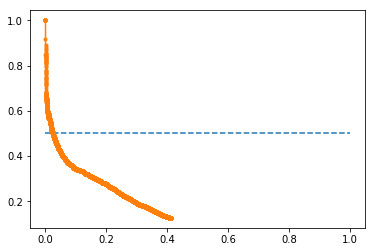

1: 0.1170
mAP: 0.1170


In [33]:
if __name__ == '__main__':
    _main_('config.json')

valid_annot_folder not exists. Spliting the trainining set.
Seen labels: 	{'1': 16916}

Given labels: 	1

Training on: 	['1']


Loading pretrained weights.

Epoch 1/1
resizing:  416 416
30/30 [==============================] - 6042s 201s/step - loss: 192.8628 - yolo_layer_7_loss: 26.2293 - yolo_layer_8_loss: 75.5665 - yolo_layer_9_loss: 91.0669

Epoch 00001: loss improved from inf to 192.86275, saving model to car.h5


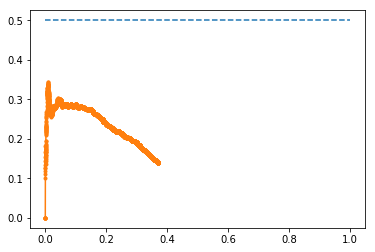

1: 0.0895
mAP: 0.0895


In [34]:
_main_('config.json')

In [ ]:
_main_('config.json')

valid_annot_folder not exists. Spliting the trainining set.
Seen labels: 	{'1': 16916}

Given labels: 	1

Training on: 	['1']


Loading pretrained weights.

Epoch 1/1
resizing:  416 416
22/30 [=====================>........] - ETA: 26:20 - loss: 176.1737 - yolo_layer_10_loss: 23.8501 - yolo_layer_11_loss: 70.9372 - yolo_layer_12_loss: 81.3864

In [ ]:
_main_('config.json')

valid_annot_folder not exists. Spliting the trainining set.
Seen labels: 	{'1': 16916}

Given labels: 	1

Training on: 	['1']


Loading pretrained weights.



C:\ProgramData\Anaconda3\envs\python36\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/1
resizing:  416 416
48/60 [=======================>......] - ETA: 14:31 - loss: 133.1811 - yolo_layer_1_loss: 21.7978 - yolo_layer_2_loss: 52.7849 - yolo_layer_3_loss: 58.5984

## 4. Predict Image

In [1]:
#! /usr/bin/env python

import os
import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs, get_yolo_boxes_v1, preprocess_input_v1, preprocess_input
from utils.bbox import draw_boxes
from keras.models import load_model
from tqdm import tqdm
import numpy as np
from darkflow.net.build import TFNet

Using TensorFlow backend.


In [2]:
config_path  = "config.json"
input_path   = ""
output_path  = "C:\\Users\\tejas magia\\OneDrive\\Documents\\Personal\\DataScience\\DataScience\\Parking Lot service\\Car-Counting-Challenge-master\\keras-yolo3-master\\output\\"

with open(config_path) as config_buffer:    
    config = json.load(config_buffer)

makedirs(output_path)

###############################
#   Set some parameter
###############################       
net_h, net_w = 256, 256 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh = 0.85, 0.7

###############################
#   Load the model
###############################
os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
infer_model = load_model(config['train']['saved_weights_name'])

###############################
#   Predict bounding boxes 
###############################
# do detection on an image
# the main loop
predicted_image_path = 'C:\\Users\\tejas magia\\OneDrive\\Documents\\Personal\\DataScience\\DataScience' + \
    '\\Parking Lot service\\Car-Counting-Challenge-master\\keras-yolo3-master\\input\\0_Rainy.jpg'
predicted_image = cv2.imread(predicted_image_path)

# predict the bounding boxes
predicted_parking_boxes = get_yolo_boxes(infer_model, [predicted_image], net_h, net_w,
                                         config['model']['anchors'], obj_thresh, nms_thresh)[0]

full_parking_image = cv2.imread('C:\\Users\\tejas magia\\OneDrive\\Documents\\Personal\\DataScience\\DataScience' + \
    '\\Parking Lot service\\Car-Counting-Challenge-master\\keras-yolo3-master\\input1\\8_Rainy.jpg')
# predict the bounding boxes
full_parking_boxes = get_yolo_boxes(infer_model, [full_parking_image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]

C:\ProgramData\Anaconda3\envs\python36\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
print(len(full_parking_boxes), len(predicted_parking_boxes))

322 166


In [12]:
pred_boxes = np.array([[box.xmin, box.ymin, box.xmax, box.ymax, box.get_score()] for box in predicted_parking_boxes])
fullpark_boxes = np.array([[box.xmin, box.ymin, box.xmax, box.ymax, box.get_score()] for box in full_parking_boxes])

In [14]:
iou_threshold=0.5
obj_thresh=0.85
nms_thresh=0.5
net_h=256
net_w=256

In [10]:
from utils.utils import evaluate
from voc import parse_voc_annotationv1
from generator import BatchGenerator
from utils.utils import normalize, evaluate,compute_overlap

In [70]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    
    union = w1*h1 + w2*h2 - intersect
    #print(box1, box2, intersect, union)
    return float(intersect) / union

In [71]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 

In [78]:
def do_nms(boxes, nms_thresh):
    iou_boxes = []
    if len(boxes) > 0:
        nb_class = 1
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-1 for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                checkdupbox = []
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    item_present = False
                    for box in iou_boxes:
                        if (boxes[index_j][0] == box[0] and boxes[index_j][1] == box[1] and boxes[index_j][2] == box[2] 
                                         and boxes[index_j][3] == box[3] and boxes[index_j][4] == box[4]):
                            item_present = True
                            break
                                      
                    if not item_present:
                        iou_boxes.append(boxes[index_j]) 
    return iou_boxes

In [73]:
from utils.colors import get_color
def draw_boxes1(image, boxes, obj_thresh, lable_color=0, quiet=True):
    for box in boxes:
        xmin = int(box[0]) if box[0] >= 0 else 0 
        ymin = int(box[1]) if box[1] >= 0 else 0 
        xmax = int(box[2]) if box[2] >= 0 else 0 
        ymax = int(box[3]) if box[3] >= 0 else 0 
        image = cv2.circle(img=image, center=(box[5], box[6]), radius=3, color=get_color(lable_color), thickness=2)
        
    return image  

In [113]:
def createboxes(source, destination,occupancy_flag):
    filter_overlapping_box = []
    detections           = source
    annotations          = destination
    detected_annotations = []
    #print(" Total Detection - {0}".format(len(detections)))
    for d in detections:
        overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
        assigned_annotation = np.argmax(overlaps, axis=1)
        max_overlap         = overlaps[0, assigned_annotation]
        #print("overlaps {0}, assigned_annotation {1}, max_overlap {2}, iou_threshold {3}".format(overlaps,assigned_annotation,max_overlap,iou_threshold))
        if (occupancy_flag == 1):
            # occupied parking slot
            if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                #print("predicted correctly {0}".format(_count))
                item_present = False
                detected_annotations.append(assigned_annotation)
                for box in filter_overlapping_box:
                    if (d[0] == box[0] and d[1] == box[1] and d[2] == box[2] and d[3] == box[3] and d[4] == box[4]):
                        item_present = True
                        break

                if not item_present:
                    pose = 2
                    height = int(d[3]) - int(d[1])
                    width = int(d[2]) - int(d[0])
                    if (height > width):
                        pose = 0
                    filter_overlapping_box.append([int(d[0]),int(d[1]),int(d[2]),int(d[3]),d[4], int((d[0]+d[2])/2), int((d[1]+d[3])/2), occupancy_flag, 0, pose])
        else:
            #Empty parking slot
            if max_overlap < iou_threshold:
                #print("predicted correctly {0}".format(_count))
                item_present = False
                detected_annotations.append(assigned_annotation)
                for box in pred_boxes:
                    if (d[0] == box[0] and d[1] == box[1] and d[2] == box[2] and d[3] == box[3] and d[4] == box[4]):
                        item_present = True
                        break

                if not item_present:
                    filter_overlapping_box.append([int(d[0]),int(d[1]),int(d[2]),int(d[3]),d[4], int((d[0]+d[2])/2), int((d[1]+d[3])/2), occupancy_flag, 0, 0])
                    
    return filter_overlapping_box

In [114]:
pred_occupied_boxes = createboxes(pred_boxes, fullpark_boxes, 1)
pred_empty_boxes = createboxes(fullpark_boxes, pred_boxes, 0)

In [77]:
print(len(pred_occupied_boxes),len(pred_empty_boxes))

106 203


In [79]:
predicted_image1 = cv2.imread(predicted_image_path)

# draw bounding boxes on the image using labels
predicted_image1 = draw_boxes1(predicted_image1.copy(), pred_empty_boxes, 0.85, 1)

# draw bounding boxes on the image using labels
predicted_image1 = draw_boxes1(predicted_image1.copy(), pred_occupied_boxes, 0.85, 0) 

# write the image with bounding boxes to file
cv2.imwrite('output\\output_predicted_' + predicted_image_path.split('\\')[-1], (predicted_image1).astype('uint8'))

True

In [80]:
from PIL import Image
def crop(image_path, coords, saved_location):
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)

In [82]:
i = 0
for d in pred_occupied_boxes:
    crop(predicted_image_path,(d[0],d[1],d[2],d[3]),'output\\predicted\\{0}.png'.format(i))
    i = i + 1

In [111]:
from sklearn.cluster import KMeans
import cv2
import os
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import image as img1
import pandas as pd
from scipy.cluster.vq import whiten
                
class DominantColors:
    CLUSTERS = None
    IMAGEPATH = None
    IMAGE = None
    COLORS = None
    LABELS = None
    BASEWIDTH = 256
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGEPATH = image

    def dominantColors(self):

        # read image
        img = cv2.imread(self.IMAGEPATH)
        
        #resize image
        imgh, imgw, _ = img.shape
        wpercent = (self.BASEWIDTH / float(imgw))
        hsize = int((float(imgh) * float(wpercent)))
        img = cv2.resize(img, (self.BASEWIDTH, hsize), PIL.Image.ANTIALIAS)

        # convert to rgb from bgr
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)

        # reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))

        # save image after operations
        self.IMAGE = img

        # using k-means to cluster pixels
        kmeans = KMeans(n_clusters=self.CLUSTERS)
        kmeans.fit(img)

        # the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_

        # save labels
        self.LABELS = kmeans.labels_

        # returning after converting to integer from float
        return self.COLORS.astype(int)
    
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    
    def analyseRGB(self):
        r = []
        g = []
        b = []
        image = img1.imread(self.IMAGEPATH)
        for line in image:
            for pixel in line:
                #print(pixel)
                temp_r, temp_g, temp_b = pixel
                r.append(temp_r)
                g.append(temp_g)
                b.append(temp_b)
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(r, g, b)
        plt.show()
        df = pd.DataFrame({'red': r,'blue': b,'green': g})
        df['scaled_red'] = whiten(df['red'])
        df['scaled_blue'] = whiten(df['blue'])
        df['scaled_green'] = whiten(df['green'])
        df.sample(n = 10)
        from scipy.cluster.vq import kmeans
        cluster_centers, distortion = kmeans(df[['scaled_red', 'scaled_green', 'scaled_blue']], 2)
        print(cluster_centers)
        colors = []
        r_std, g_std, b_std = df[['red', 'green', 'blue']].std()
        for cluster_center in cluster_centers:
            scaled_r, scaled_g, scaled_b = cluster_center
            colors.append((scaled_r * r_std / 255,scaled_g * g_std / 255,scaled_b * b_std / 255))
        plt.imshow([colors])
        plt.show()

    def plotClusters(self):
        #plotting 
        fig = plt.figure()
        ax = Axes3D(fig)        
        for label, pix in zip(self.LABELS, self.IMAGE):
            ax.scatter(pix[0], pix[1], pix[2], color = self.rgb_to_hex(self.COLORS[label]))
        plt.show()
    
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

In [ ]:
clusters = 8
for img in sorted(os.listdir('output\\predicted\\')):
    print(img)
    dc = DominantColors('output\\predicted\\{0}'.format(img), clusters)
    colors = dc.dominantColors()
    dc.analyseRGB()

In [ ]:
import json

In [121]:
def writeToJSONFile(path, fileName, data):
    filePathNameWExt = path + fileName + '.json'
    with open(filePathNameWExt, 'w') as fp:
        json.dump(data, fp)

In [122]:
# output Result setting
modified_pred_occupied_boxes = [[d[5],d[6],d[7],d[8],d[9]] for d in pred_occupied_boxes]
#Data
boxes = modified_pred_occupied_boxes

#Create dict
dic = {}
dic['filename'] = predicted_image_path
dic['parking_lots'] = boxes

#print(dic)

#Dump data dict to json
writeToJSONFile('data\\annotations\\','annotations',dic)

## 5. Evaluate

In [186]:
from utils.utils import evaluate
from voc import parse_voc_annotationv1
from generator import BatchGenerator
from utils.utils import normalize, evaluate,compute_overlap

In [182]:
config_path = "config.json"

with open(config_path) as config_buffer:    
    config = json.loads(config_buffer.read())

###############################
#   Create the validation generator
###############################  
valid_ints, labels = parse_voc_annotationv1(
    config['valid']['valid_annot_folder'], 
    config['valid']['valid_image_folder'], 
    config['valid']['cache_name'],
    config['model']['labels']
)

labels = labels.keys() if len(config['model']['labels']) == 0 else config['model']['labels']
labels = sorted(labels)

valid_generator = BatchGenerator(
    instances           = valid_ints, 
    anchors             = config['model']['anchors'],   
    labels              = labels,        
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = 0,
    batch_size          = config['train']['batch_size'],
    min_net_size        = config['model']['min_input_size'],
    max_net_size        = config['model']['max_input_size'],   
    shuffle             = True, 
    jitter              = 0.0, 
    norm                = normalize
)

###############################
#   Load the model and do evaluation
###############################
os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']

In [ ]:
infer_model = load_model(config['train']['saved_weights_name'])

In [183]:
predicted_image_path1 = 'C:\\Users\\tejas magia\\OneDrive\\Documents\\Personal\\DataScience\\DataScience' + \
    '\\Parking Lot service\\Car-Counting-Challenge-master\\keras-yolo3-master\\PredictImage\\0_Rainy.jpg'
predicted_image1 = cv2.imread(predicted_image_path1)

In [315]:
def evaluate1(model, 
             generator,
             predict_image,
             iou_threshold=0.5,
             obj_thresh=0.85,
             nms_thresh=0.5,
             net_h=256,
             net_w=256,
             save_path=None):
    #    """ Evaluate a given dataset using a given model.
    #    code originally from https://github.com/fizyr/keras-retinanet
    #
    #    # Arguments
    #        model           : The model to evaluate.
    #        generator       : The generator that represents the dataset to evaluate.
    #        iou_threshold   : The threshold used to consider when a detection is positive or negative.
    #        obj_thresh      : The threshold used to distinguish between object and non-object
    #        nms_thresh      : The threshold used to determine whether two detections are duplicates
    #        net_h           : The height of the input image to the model, higher value results in better accuracy
    #        net_w           : The width of the input image to the model
    #        save_path       : The path to save images with visualized detections to.
    #    # Returns
    #        A dict mapping class names to mAP scores.
    #    """    
    # gather all detections and annotations
    all_detections     = [[None for i in range(generator.num_classes())] for j in range(generator.size())]
    all_annotations    = [[None for i in range(generator.num_classes())] for j in range(generator.size())]

    for i in range(generator.size()):
        raw_image = [predict_image]

        # make the boxes and the labels
        pred_boxes = get_yolo_boxes(model, raw_image, net_h, net_w, generator.get_anchors(), obj_thresh, nms_thresh)[0]

        score = np.array([box.get_score() for box in pred_boxes])
        pred_labels = np.array([box.label for box in pred_boxes])

        if len(pred_boxes) > 0:
            pred_boxes = np.array([[box.xmin, box.ymin, box.xmax, box.ymax, box.get_score()] for box in pred_boxes])
        else:
            pred_boxes = np.array([[]])

        # sort the boxes and the labels according to scores
        score_sort = np.argsort(-score)
        pred_labels = pred_labels[score_sort]
        pred_boxes  = pred_boxes[score_sort]

        # copy detections to all_detections
        for label in range(generator.num_classes()):
            all_detections[i][label] = pred_boxes[pred_labels == label, :]

        annotations = generator.load_annotation(i)

        # copy detections to all_annotations
        for label in range(generator.num_classes()):
            all_annotations[i][label] = annotations[annotations[:, 4] == label, :4].copy()

    # compute mAP by comparing all detections and all annotations
    average_precisions = {}
    filter_overlapping_box = []
    for label in range(generator.num_classes()):
        print(label)
        false_positives = np.zeros((0,))
        true_positives  = np.zeros((0,))
        scores          = np.zeros((0,))
        num_annotations = 0.0

        for i in range(generator.size()):
            #print(" i - {0}".format(i))
            detections           = all_detections[i][label]
            annotations          = all_annotations[i][label]
            num_annotations     += annotations.shape[0]
            detected_annotations = []
            #print(" Total Detection - {0}".format(len(detections)))
            for d in detections:
                scores = np.append(scores, d[4])

                if annotations.shape[0] == 0:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)
                    continue

                overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap         = overlaps[0, assigned_annotation]
                #print("overlaps {0}, assigned_annotation {1}, max_overlap {2}, iou_threshold {3}".format(overlaps,assigned_annotation,max_overlap,iou_threshold))
                if max_overlap >= iou_threshold: #and assigned_annotation not in detected_annotations:
                    #print("predicted correctly {0}".format(_count))
                    false_positives = np.append(false_positives, 0)
                    true_positives  = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)
                    item_present = False
                    for box in filter_overlapping_pre_box:
                        if (d[0] == box[0] and d[1] == box[1] and d[2] == box[2] and d[3] == box[3] and d[4] == box[4]):
                            item_present = True
                            break

                    if not item_present:
                        filter_overlapping_box.append(d) 
                else:
                    #print("predicted Incorrectly {0}".format(_incorrect_count))
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0) 

    #print(len(all_annotations))
    return filter_overlapping_box

In [316]:
full_parking_image_path1 = 'C:\\Users\\tejas magia\\OneDrive\\Documents\\Personal\\DataScience\\DataScience' + \
    '\\Parking Lot service\\Car-Counting-Challenge-master\\keras-yolo3-master\\input1\\8_Rainy.jpg'
full_parking_image1 = cv2.imread(full_parking_image_path1)

In [317]:
#full_parked_img_occupied_slot = evaluate1(infer_model, valid_generator, full_parking_image1, 0.5,0.85,0.5,256,256)
predicted_img_occupied_slot = evaluate1(infer_model, valid_generator, predicted_image1, 0.5,0.85,0.5,256,256)

# print the score
#for label, average_precision in average_precisions.items():
#    print(labels[label] + ': {:.4f}'.format(average_precision))
#print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions))) http://localhost:8888/notebooks/OneDrive/Documents/Personal/DataScience/DataScience/Parking%20Lot%20service/Car-Counting-Challenge-master/keras-yolo3-master/Submission/training/Analysed%20Train%2C%20Test%2C%20Predict%20and%20IOU%20analysis.ipynb#

0


In [319]:
print(generator.size())

120


In [320]:
print(len(predicted_img_occupied_slot))
#print(len(filter_overlapping_empty_box))

4357


In [248]:
parked_uniques = do_nms(filter_overlapping_pre_box, 0.5)
empty_parked_uniques = do_nms(filter_overlapping_empty_box,0.5)

In [258]:
print(len(filter_overlapping_pre_box),len(filter_overlapping_empty_box))
print(filter_overlapping_pre_box)

127 166
[array([920.        ,  -1.        , 950.        ,  37.        ,
         0.99214411]), array([535.        ,  10.        , 565.        ,  46.        ,
         0.98973304]), array([641.        , 261.        , 690.        , 307.        ,
         0.98916733]), array([842.        , 149.        , 878.        , 192.        ,
         0.98835504]), array([9.74000000e+02, 2.00000000e+00, 1.00500000e+03, 3.90000000e+01,
       9.87886429e-01]), array([409.        , 304.        , 451.        , 358.        ,
         0.98781896]), array([934.        , 305.        , 973.        , 361.        ,
         0.98768407]), array([488.        , 305.        , 532.        , 362.        ,
         0.98756486]), array([875.        , 177.        , 913.        , 231.        ,
         0.98678219]), array([  8.        , 195.        ,  38.        , 232.        ,
         0.98670292]), array([565.        , 305.        , 614.        , 361.        ,
         0.98625505]), array([231.        ,  83.        , 

         0.98695254]), array([807., 663., 869., 721.,   0.]), array([ 991.,  175., 1031.,  227.,    0.]), array([ 971.,  429., 1020.,  502.,    0.]), array([331.       ,  30.       , 363.       ,  65.       ,   0.9841724])]


In [326]:
full_parked_image_path1 = 'C:\\Users\\tejas magia\\OneDrive\\Documents\\Personal\\DataScience\\DataScience' + \
    '\\Parking Lot service\\Car-Counting-Challenge-master\\keras-yolo3-master\\FullParkImage\\8_Rainy.jpg'
full_park_image1 = cv2.imread(full_parked_image_path1)
#print(predicted_image1.shape)
#predicted_image1 = draw_boxes1(predicted_image1.copy(),filter_overlapping_empty_box,0.85,1)
full_park_image1 = draw_boxes1(full_park_image1.copy(),predicted_img_occupied_slot,0.85,5)
# write the image with bounding boxes to file
cv2.imwrite('output\\output_predicted_' + full_parked_image_path1.split('\\')[-1], (full_park_image1).astype('uint8'))

True

In [327]:
predicted_image_path1 = 'C:\\Users\\tejas magia\\OneDrive\\Documents\\Personal\\DataScience\\DataScience' + \
    '\\Parking Lot service\\Car-Counting-Challenge-master\\keras-yolo3-master\\PredictImage\\0_Rainy.jpg'
predicted_image1 = cv2.imread(predicted_image_path1)
#print(predicted_image1.shape)
#predicted_image1 = draw_boxes1(predicted_image1.copy(),filter_overlapping_empty_box,0.85,1)
predicted_image1 = draw_boxes1(predicted_image1.copy(),predicted_img_occupied_slot,0.85,5)
# write the image with bounding boxes to file
cv2.imwrite('output\\output_predicted_' + predicted_image_path1.split('\\')[-1], (predicted_image1).astype('uint8'))

True